In [1]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [2]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [3]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [4]:
qfl_factors = globals()['qfl_{0}'.format('Market Sensitivity').lower()] # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [5]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [6]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [7]:
qfl_df = df

In [8]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_BETA(0,LEVEL,21D)","QFL_BETA(0,LEVEL,63D)","QFL_BETA(0,LEVEL,252D)","QFL_BETA(0,LEVEL,36M)","QFL_BETA(0,LEVEL,60M)","QFL_BETA(0,R2,21D)","QFL_BETA(0,R2,63D)","QFL_BETA(0,R2,252D)","QFL_BETA(0,R2,36M)","QFL_BETA(0,R2,60M)","QFL_BETA(0,INTERCEPT,21D)","QFL_BETA(0,INTERCEPT,63D)","QFL_BETA(0,INTERCEPT,252D)","QFL_BETA(0,INTERCEPT,36M)","QFL_BETA(0,INTERCEPT,60M)","QFL_UPBETA(0,LEVEL,21D)","QFL_UPBETA(0,LEVEL,63D)","QFL_UPBETA(0,LEVEL,252D)","QFL_UPBETA(0,LEVEL,36M)","QFL_UPBETA(0,LEVEL,60M)","QFL_UPBETA(0,R2,21D)","QFL_UPBETA(0,R2,63D)","QFL_UPBETA(0,R2,252D)","QFL_UPBETA(0,R2,36M)","QFL_UPBETA(0,R2,60M)","QFL_UPBETA(0,INTERCEPT,21D)","QFL_UPBETA(0,INTERCEPT,63D)","QFL_UPBETA(0,INTERCEPT,252D)","QFL_UPBETA(0,INTERCEPT,36M)","QFL_UPBETA(0,INTERCEPT,60M)","QFL_DOWNBETA(0,LEVEL,21D)","QFL_DOWNBETA(0,LEVEL,63D)","QFL_DOWNBETA(0,LEVEL,252D)","QFL_DOWNBETA(0,LEVEL,36M)","QFL_DOWNBETA(0,LEVEL,60M)","QFL_DOWNBETA(0,R2,21D)","QFL_DOWNBETA(0,R2,63D)","QFL_DOWNBETA(0,R2,252D)","QFL_DOWNBETA(0,R2,36M)","QFL_DOWNBETA(0,R2,60M)","QFL_DOWNBETA(0,INTERCEPT,21D)","QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)","QFL_DOWNBETA(0,INTERCEPT,60M)"
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,0.861591,1.610198,1.118509,1.302228,1.346245,0.244189,0.624214,0.697611,0.493239,0.436854,0.025345,-0.160741,0.182982,2.127070,1.485300,1.563566,2.037778,1.107488,1.104269,1.464730,0.284010,0.442904,0.526650,0.138878,0.217026,-0.950105,-0.780763,0.215011,3.217354,1.149191,0.890417,1.896566,1.103299,1.027167,1.155172,0.137158,0.531894,0.651620,0.360123,0.375939,0.318550,0.361035,0.119952,-0.119393,0.645002
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,1.251734,1.392137,1.124283,0.879081,0.879282,0.450638,0.734557,0.781973,0.664893,0.506620,-0.321641,-0.135252,0.088684,2.014583,1.707961,1.489957,1.349847,1.153005,0.539854,0.767634,0.315103,0.382836,0.644525,0.206734,0.213866,-0.580456,-0.147045,0.079986,3.840337,2.410959,0.327754,1.558148,1.072252,0.483585,0.559072,0.015892,0.668159,0.739606,0.220694,0.250698,-0.715076,0.103369,-0.027884,-1.318583,-0.373123
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,0.977121,1.385195,0.683623,1.113462,1.171633,0.179004,0.520609,0.375052,0.426010,0.389396,-0.253297,-0.177563,0.210121,2.062143,1.769571,1.486608,1.762081,0.614779,1.336714,1.087001,0.153935,0.263224,0.218852,0.272714,0.189366,-0.919348,-0.563695,0.388769,1.343956,2.453193,0.481733,1.238941,0.639716,0.512783,0.733700,0.019361,0.391755,0.267635,0.048014,0.111707,-0.306034,-0.302111,-0.004324,-1.605728,-0.928978
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,1.431287,1.344539,0.992680,1.309334,1.181302,0.321083,0.475149,0.561336,0.577974,0.432414,-0.430363,-0.143153,0.100999,0.318377,0.728503,2.222191,1.258325,0.903688,1.843832,1.475115,0.267217,0.146442,0.321812,0.397825,0.266027,-1.432395,-0.034543,0.219383,-1.958213,-0.215105,0.214552,1.341049,1.051975,0.863571,0.850114,0.016337,0.367187,0.586196,0.370470,0.305427,-0.758130,-0.163126,0.159252,-1.707052,-0.536148
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,1.214249,1.264529,0.945652,1.075778,1.060477,0.546202,0.647995,0.728113,0.610324,0.507022,-0.190792,0.017097,0.061746,0.697114,0.573646,1.406342,0.913093,0.869954,0.951692,1.020823,0.355076,0.218818,0.518126,0.291591,0.259901,-0.413201,0.351598,0.208426,1.159476,0.738445,0.644602,1.476014,0.951700,1.297097,1.056681,0.143165,0.551272,0.709173,0.422939,0.376638,-0.415955,0.248248,-0.013721,1.969548,0.465832


In [9]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_BETA(0,LEVEL,21D)","QFL_BETA(0,LEVEL,63D)","QFL_BETA(0,LEVEL,252D)","QFL_BETA(0,LEVEL,36M)","QFL_BETA(0,LEVEL,60M)","QFL_BETA(0,R2,21D)","QFL_BETA(0,R2,63D)","QFL_BETA(0,R2,252D)","QFL_BETA(0,R2,36M)","QFL_BETA(0,R2,60M)","QFL_BETA(0,INTERCEPT,21D)","QFL_BETA(0,INTERCEPT,63D)","QFL_BETA(0,INTERCEPT,252D)","QFL_BETA(0,INTERCEPT,36M)","QFL_BETA(0,INTERCEPT,60M)","QFL_UPBETA(0,LEVEL,21D)","QFL_UPBETA(0,LEVEL,63D)","QFL_UPBETA(0,LEVEL,252D)","QFL_UPBETA(0,LEVEL,36M)","QFL_UPBETA(0,LEVEL,60M)","QFL_UPBETA(0,R2,21D)","QFL_UPBETA(0,R2,63D)","QFL_UPBETA(0,R2,252D)","QFL_UPBETA(0,R2,36M)","QFL_UPBETA(0,R2,60M)","QFL_UPBETA(0,INTERCEPT,21D)","QFL_UPBETA(0,INTERCEPT,63D)","QFL_UPBETA(0,INTERCEPT,252D)","QFL_UPBETA(0,INTERCEPT,36M)","QFL_UPBETA(0,INTERCEPT,60M)","QFL_DOWNBETA(0,LEVEL,21D)","QFL_DOWNBETA(0,LEVEL,63D)","QFL_DOWNBETA(0,LEVEL,252D)","QFL_DOWNBETA(0,LEVEL,36M)","QFL_DOWNBETA(0,LEVEL,60M)","QFL_DOWNBETA(0,R2,21D)","QFL_DOWNBETA(0,R2,63D)","QFL_DOWNBETA(0,R2,252D)","QFL_DOWNBETA(0,R2,36M)","QFL_DOWNBETA(0,R2,60M)","QFL_DOWNBETA(0,INTERCEPT,21D)","QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)","QFL_DOWNBETA(0,INTERCEPT,60M)"
1595,890100,30-Nov-2020,BZ22BK,0.002738,SmartCentres Real Estate Investment Trust,Real Estate,Canada,-3.552645,Mid Cap,2688.3582,1.859705,1.022785,1.089385,1.212084,1.138804,0.151393,0.158520,0.497189,0.713975,0.567979,-0.146520,0.221638,-0.043206,-0.048561,-0.307388,2.188848,0.981199,0.803405,1.115507,1.167896,0.081743,0.032091,0.221651,0.532579,0.446300,-0.380204,0.308286,0.310197,-0.431164,-1.342744,0.076826,0.761004,1.224969,1.654241,1.699027,0.003275,0.153633,0.559526,0.778752,0.752188,-1.430627,-0.073195,0.014579,3.147473,3.488408
1596,890100,30-Nov-2020,B2NT8S,0.002637,"Seven Bank, Ltd.",Financials,Japan,-4.803491,Mid Cap,2619.2988,0.634806,0.808760,0.661598,0.732832,0.787571,0.259464,0.382423,0.330719,0.357374,0.290527,-0.518221,-0.276849,-0.149049,-0.946319,-1.156830,0.670522,0.806176,0.525532,-0.108395,0.441703,0.143131,0.207745,0.123819,0.003855,0.028514,-0.506588,-0.262086,0.044308,2.819901,-0.007982,0.386984,0.833457,0.697825,0.493324,0.959254,0.122166,0.224130,0.292861,0.126226,0.285005,-0.634480,-0.232353,-0.161058,-3.069147,-0.515737
1597,890100,30-Nov-2020,BKSLS5,0.002617,First Capital Real Estate Investment Trust,Real Estate,Canada,-12.513375,Mid Cap,2634.8494,2.692586,1.370205,0.808081,1.275458,1.215721,0.272787,0.215884,0.318258,0.617203,0.551272,0.141046,0.226625,-0.069289,-0.478935,-0.360776,3.702553,1.978257,0.521001,1.437898,1.348439,0.212935,0.107731,0.091988,0.386067,0.354504,-0.699374,-0.130267,0.381795,-1.669870,-1.452212,0.473571,0.663496,0.875868,1.523415,1.573937,0.025447,0.071887,0.360945,0.803456,0.815251,-1.024660,-0.397286,-0.226699,1.860700,2.372047
1598,890100,30-Nov-2020,659844,0.002463,Mitsubishi Motors Corporation,Consumer Discretionary,Japan,15.425528,Mid Cap,2808.4746,1.280147,1.694869,1.623795,1.051524,1.319276,0.149994,0.298899,0.511328,0.372829,0.252021,-0.647261,-0.633504,-0.342854,-3.440251,-2.332608,0.561178,1.523373,1.819752,0.661893,0.540273,0.013926,0.110205,0.408718,0.066813,0.015525,0.132622,-0.445803,-0.414767,-1.351233,1.402555,2.148777,1.815160,1.294108,0.664395,0.771574,0.531883,0.226789,0.294895,0.099569,0.059325,-0.284384,-0.531136,-0.673074,-5.993121,-6.138541
1599,890100,30-Nov-2020,656950,0.002419,Maruichi Steel Tube Ltd.,Materials,Japan,4.007292,Small Cap,2063.3816,0.887368,0.981956,1.070799,0.663928,0.706906,0.269560,0.299623,0.364028,0.178343,0.214594,-0.838711,-0.502465,-0.115558,-0.541654,-0.467421,-0.022732,0.487670,1.105287,0.546036,0.623914,0.000129,0.057219,0.223765,0.030071,0.044204,0.170048,-0.021062,-0.076383,0.284948,0.332867,1.795276,1.217861,0.932971,0.390893,0.320950,0.698785,0.183288,0.233452,0.049387,0.040192,-0.564077,-0.417951,-0.281489,-2.200076,-2.713551


In [10]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,"QFL_BETA(0,LEVEL,21D)","QFL_BETA(0,LEVEL,63D)","QFL_BETA(0,LEVEL,252D)","QFL_BETA(0,LEVEL,36M)","QFL_BETA(0,LEVEL,60M)","QFL_BETA(0,R2,21D)","QFL_BETA(0,R2,63D)","QFL_BETA(0,R2,252D)","QFL_BETA(0,R2,36M)","QFL_BETA(0,R2,60M)","QFL_BETA(0,INTERCEPT,21D)","QFL_BETA(0,INTERCEPT,63D)","QFL_BETA(0,INTERCEPT,252D)","QFL_BETA(0,INTERCEPT,36M)","QFL_BETA(0,INTERCEPT,60M)","QFL_UPBETA(0,LEVEL,21D)","QFL_UPBETA(0,LEVEL,63D)","QFL_UPBETA(0,LEVEL,252D)","QFL_UPBETA(0,LEVEL,36M)","QFL_UPBETA(0,LEVEL,60M)","QFL_UPBETA(0,R2,21D)","QFL_UPBETA(0,R2,63D)","QFL_UPBETA(0,R2,252D)","QFL_UPBETA(0,R2,36M)","QFL_UPBETA(0,R2,60M)","QFL_UPBETA(0,INTERCEPT,21D)","QFL_UPBETA(0,INTERCEPT,63D)","QFL_UPBETA(0,INTERCEPT,252D)","QFL_UPBETA(0,INTERCEPT,36M)","QFL_UPBETA(0,INTERCEPT,60M)","QFL_DOWNBETA(0,LEVEL,21D)","QFL_DOWNBETA(0,LEVEL,63D)","QFL_DOWNBETA(0,LEVEL,252D)","QFL_DOWNBETA(0,LEVEL,36M)","QFL_DOWNBETA(0,LEVEL,60M)","QFL_DOWNBETA(0,R2,21D)","QFL_DOWNBETA(0,R2,63D)","QFL_DOWNBETA(0,R2,252D)","QFL_DOWNBETA(0,R2,36M)","QFL_DOWNBETA(0,R2,60M)","QFL_DOWNBETA(0,INTERCEPT,21D)","QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)","QFL_DOWNBETA(0,INTERCEPT,60M)"
count,1600.0,1600.000000,1597.000000,1.598000e+03,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000
mean,890100.0,0.062500,3.118575,3.489420e+04,1.011767,0.967271,1.023585,1.052915,1.036471,0.271057,0.319903,0.473521,0.422075,0.366663,0.082961,0.058539,0.023206,0.397410,0.467363,0.921421,0.949073,1.012853,1.117010,1.053117,0.195422,0.176642,0.310625,0.249211,0.201364,0.203330,0.085428,0.033313,0.050060,0.357022,0.923624,0.941190,1.034783,1.149108,1.087238,0.247662,0.232387,0.446879,0.364357,0.322484,-0.016857,0.016362,0.041378,1.153699,0.780589
std,0.0,0.177252,7.256757,9.150908e+04,0.782549,0.421407,0.322206,0.499485,0.474365,0.213641,0.178526,0.172886,0.212550,0.193667,0.460887,0.210975,0.121473,1.449895,1.160392,0.943505,0.678124,0.397597,0.829399,0.678357,0.220104,0.175409,0.169970,0.202068,0.163422,1.028805,0.539161,0.309298,2.987257,2.148320,1.628088,0.471168,0.335326,0.729098,0.624753,0.243150,0.156785,0.175304,0.234350,0.207064,1.081773,0.473661,0.273328,3.553035,2.338678
min,890100.0,0.002419,-31.602722,2.063382e+03,-1.802172,-0.502807,-0.160131,-0.215584,-0.144400,0.000000,0.000001,0.000180,0.000056,0.000001,-2.176301,-0.633504,-0.342854,-3.874824,-3.266086,-3.025513,-1.812722,-0.686421,-1.945153,-1.100189,0.000000,0.000000,0.000006,0.000000,0.000000,-8.101402,-3.057901,-1.237435,-14.093941,-9.583545,-9.247129,-0.742680,-0.293093,-1.370584,-0.952763,0.000001,0.000051,0.000203,0.000000,0.000001,-4.502472,-3.177877,-1.238195,-9.737409,-10.800915
25%,890100.0,0.012927,-1.169592,8.494103e+03,0.542501,0.702802,0.821873,0.715928,0.724479,0.094547,0.185813,0.364886,0.255236,0.211509,-0.192247,-0.081144,-0.049688,-0.455710,-0.220615,0.381298,0.572875,0.773265,0.593158,0.610768,0.028751,0.043284,0.180094,0.077791,0.067635,-0.321791,-0.202601,-0.151958,-1.692568,-0.883261,0.121573,0.638878,0.817322,0.701458,0.696966,0.038768,0.106066,0.332209,0.157575,0.151404,-0.543147,-0.258061,-0.126118,-1.058029,-0.721078
50%,890100.0,0.024960,2.384615,1.491753e+04,0.992019,0.944555,1.026386,1.040325,1.025258,0.223808,0.301507,0.496869,0.442825,0.375092,0.064949,0.043129,0.009148,0.236832,0.404155,0.857449,0.910828,1.005069,1.057749,0.993327,0.107164,0.116688,0.308380,0.213844,0.171407,0.163799,0.092641,0.011752,0.047701,0.390226,0.95336

In [11]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID                       0
DATE                               0
SECURITY_ID                        0
Weight                             0
proper_name                        0
fg_gics_sector                     2
proper                             0
p_total_return                     3
qfl_size_class                     2
qfl_mkt_val_sec                    2
QFL_BETA(0,LEVEL,21D)              2
QFL_BETA(0,LEVEL,63D)              4
QFL_BETA(0,LEVEL,252D)             8
QFL_BETA(0,LEVEL,36M)             49
QFL_BETA(0,LEVEL,60M)             83
QFL_BETA(0,R2,21D)                 2
QFL_BETA(0,R2,63D)                 4
QFL_BETA(0,R2,252D)                8
QFL_BETA(0,R2,36M)                49
QFL_BETA(0,R2,60M)                83
QFL_BETA(0,INTERCEPT,21D)          2
QFL_BETA(0,INTERCEPT,63D)          4
QFL_BETA(0,INTERCEPT,252D)         8
QFL_BETA(0,INTERCEPT,36M)         49
QFL_BETA(0,INTERCEPT,60M)         83
QFL_UPBETA(0,LEVEL,21D)            2
QFL_UPBETA(0,LEVEL,63D)            4
Q

In [12]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].values.dtype == 'float64']

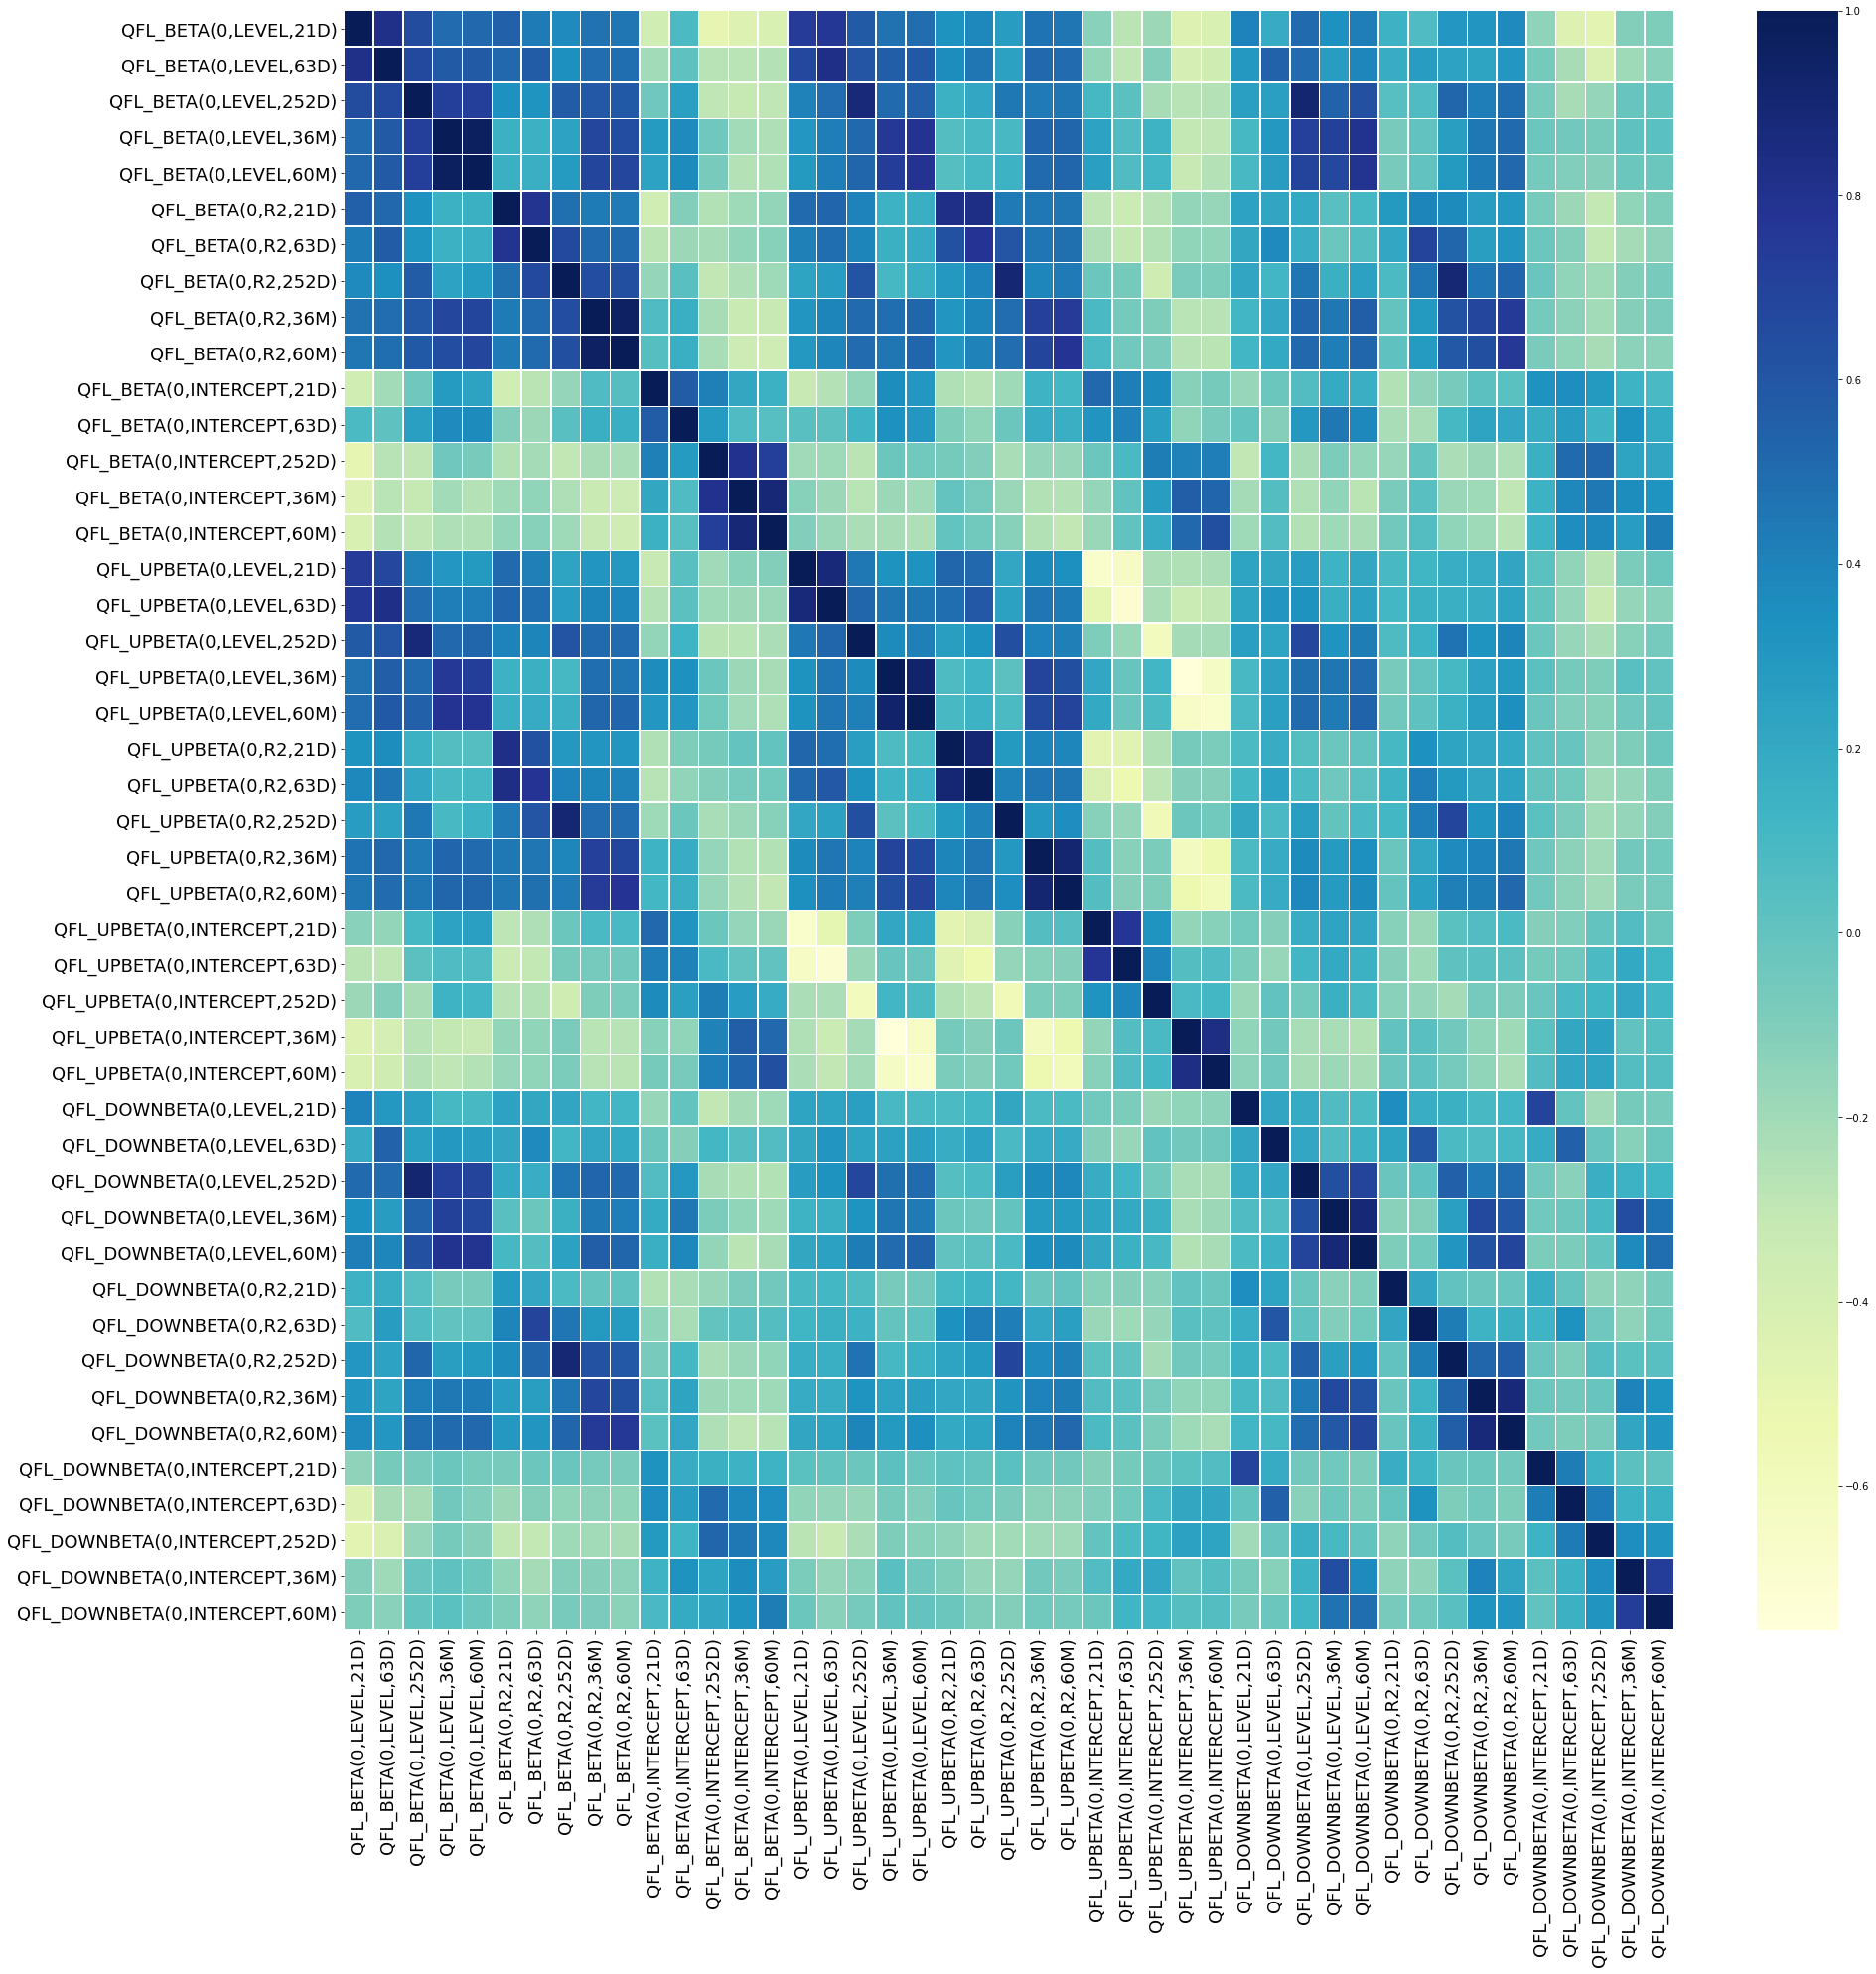

In [50]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

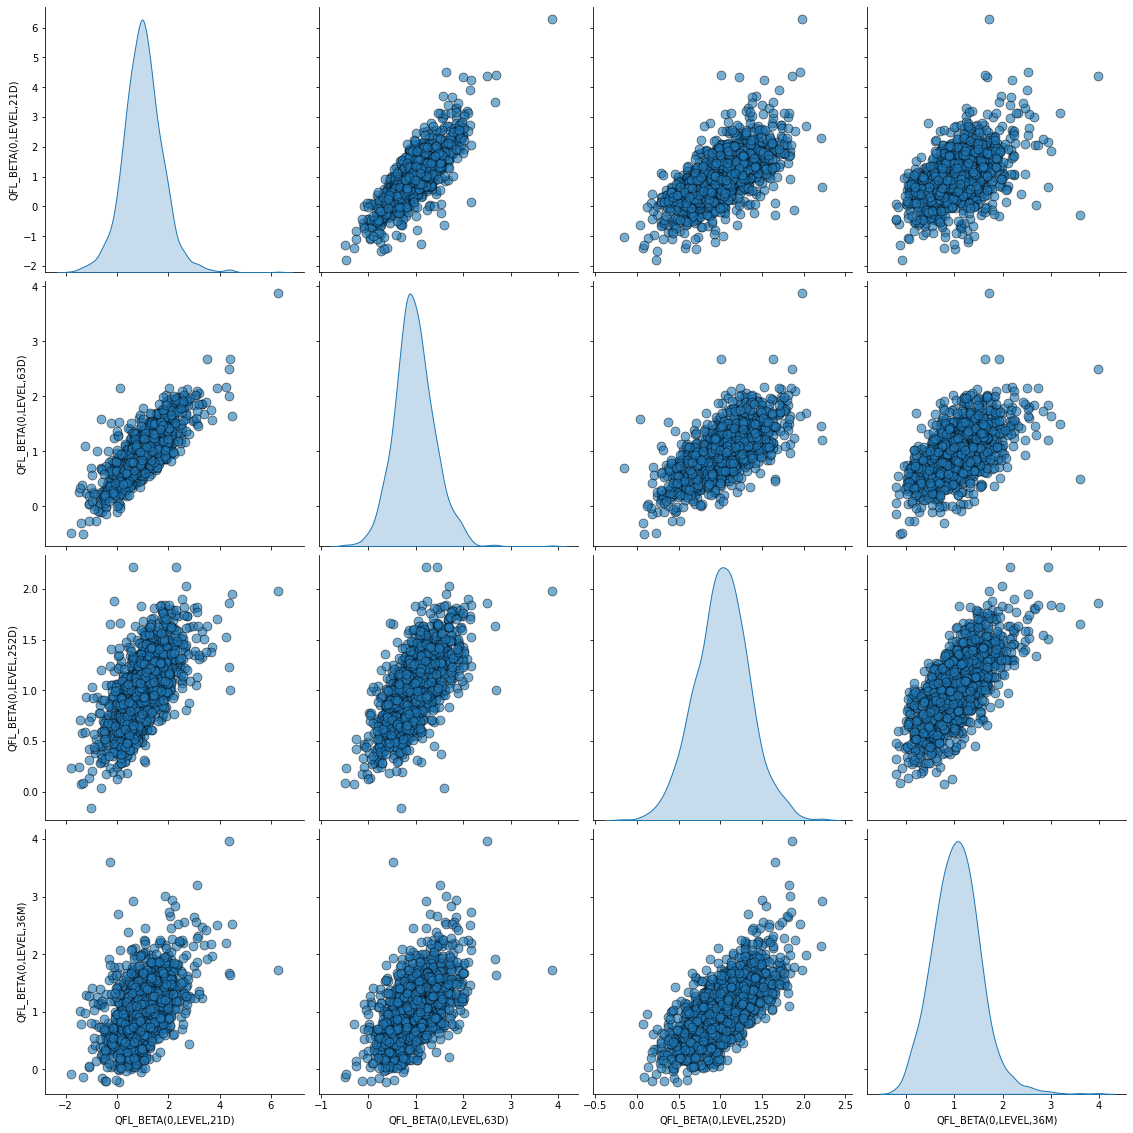

In [14]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [15]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,"QFL_BETA(0,LEVEL,21D)","QFL_BETA(0,LEVEL,63D)","QFL_BETA(0,LEVEL,252D)","QFL_BETA(0,LEVEL,36M)"
0,0.861591,1.610198,1.118509,1.302228
1,1.251734,1.392137,1.124283,0.879081
2,0.977121,1.385195,0.683623,1.113462
3,1.431287,1.344539,0.992680,1.309334
4,1.214249,1.264529,0.945652,1.075778
...,...,...,...,...
1595,1.859705,1.022785,1.089385,1.212084
1596,0.634806,0.808760,0.661598,0.732832
1597,2.692586,1.370205,0.808081,1.275458
1598,1.280147,1.694869,1.623795,1.051524


In [16]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
"QFL_BETA(0,LEVEL,21D)",1598,"[-1.8, 6.29]",1.01,0.61,0.46,2.62
"QFL_BETA(0,LEVEL,63D)",1596,"[-0.5, 3.88]",0.97,0.18,0.42,1.79
"QFL_BETA(0,LEVEL,252D)",1592,"[-0.16, 2.22]",1.02,0.1,0.02,0.26
"QFL_BETA(0,LEVEL,36M)",1551,"[-0.22, 3.97]",1.05,0.25,0.57,1.65
"QFL_BETA(0,LEVEL,60M)",1517,"[-0.14, 3.95]",1.04,0.23,0.51,1.51
"QFL_BETA(0,R2,21D)",1598,"[0.0, 0.91]",0.27,0.05,0.76,-0.19
"QFL_BETA(0,R2,63D)",1596,"[0.0, 0.86]",0.32,0.03,0.35,-0.43
"QFL_BETA(0,R2,252D)",1592,"[0.0, 0.89]",0.47,0.03,-0.48,-0.18
"QFL_BETA(0,R2,36M)",1551,"[0.0, 0.91]",0.42,0.05,-0.16,-0.86
"QFL_BETA(0,R2,60M)",1517,"[0.0, 0.88]",0.37,0.04,-0.02,-0.82


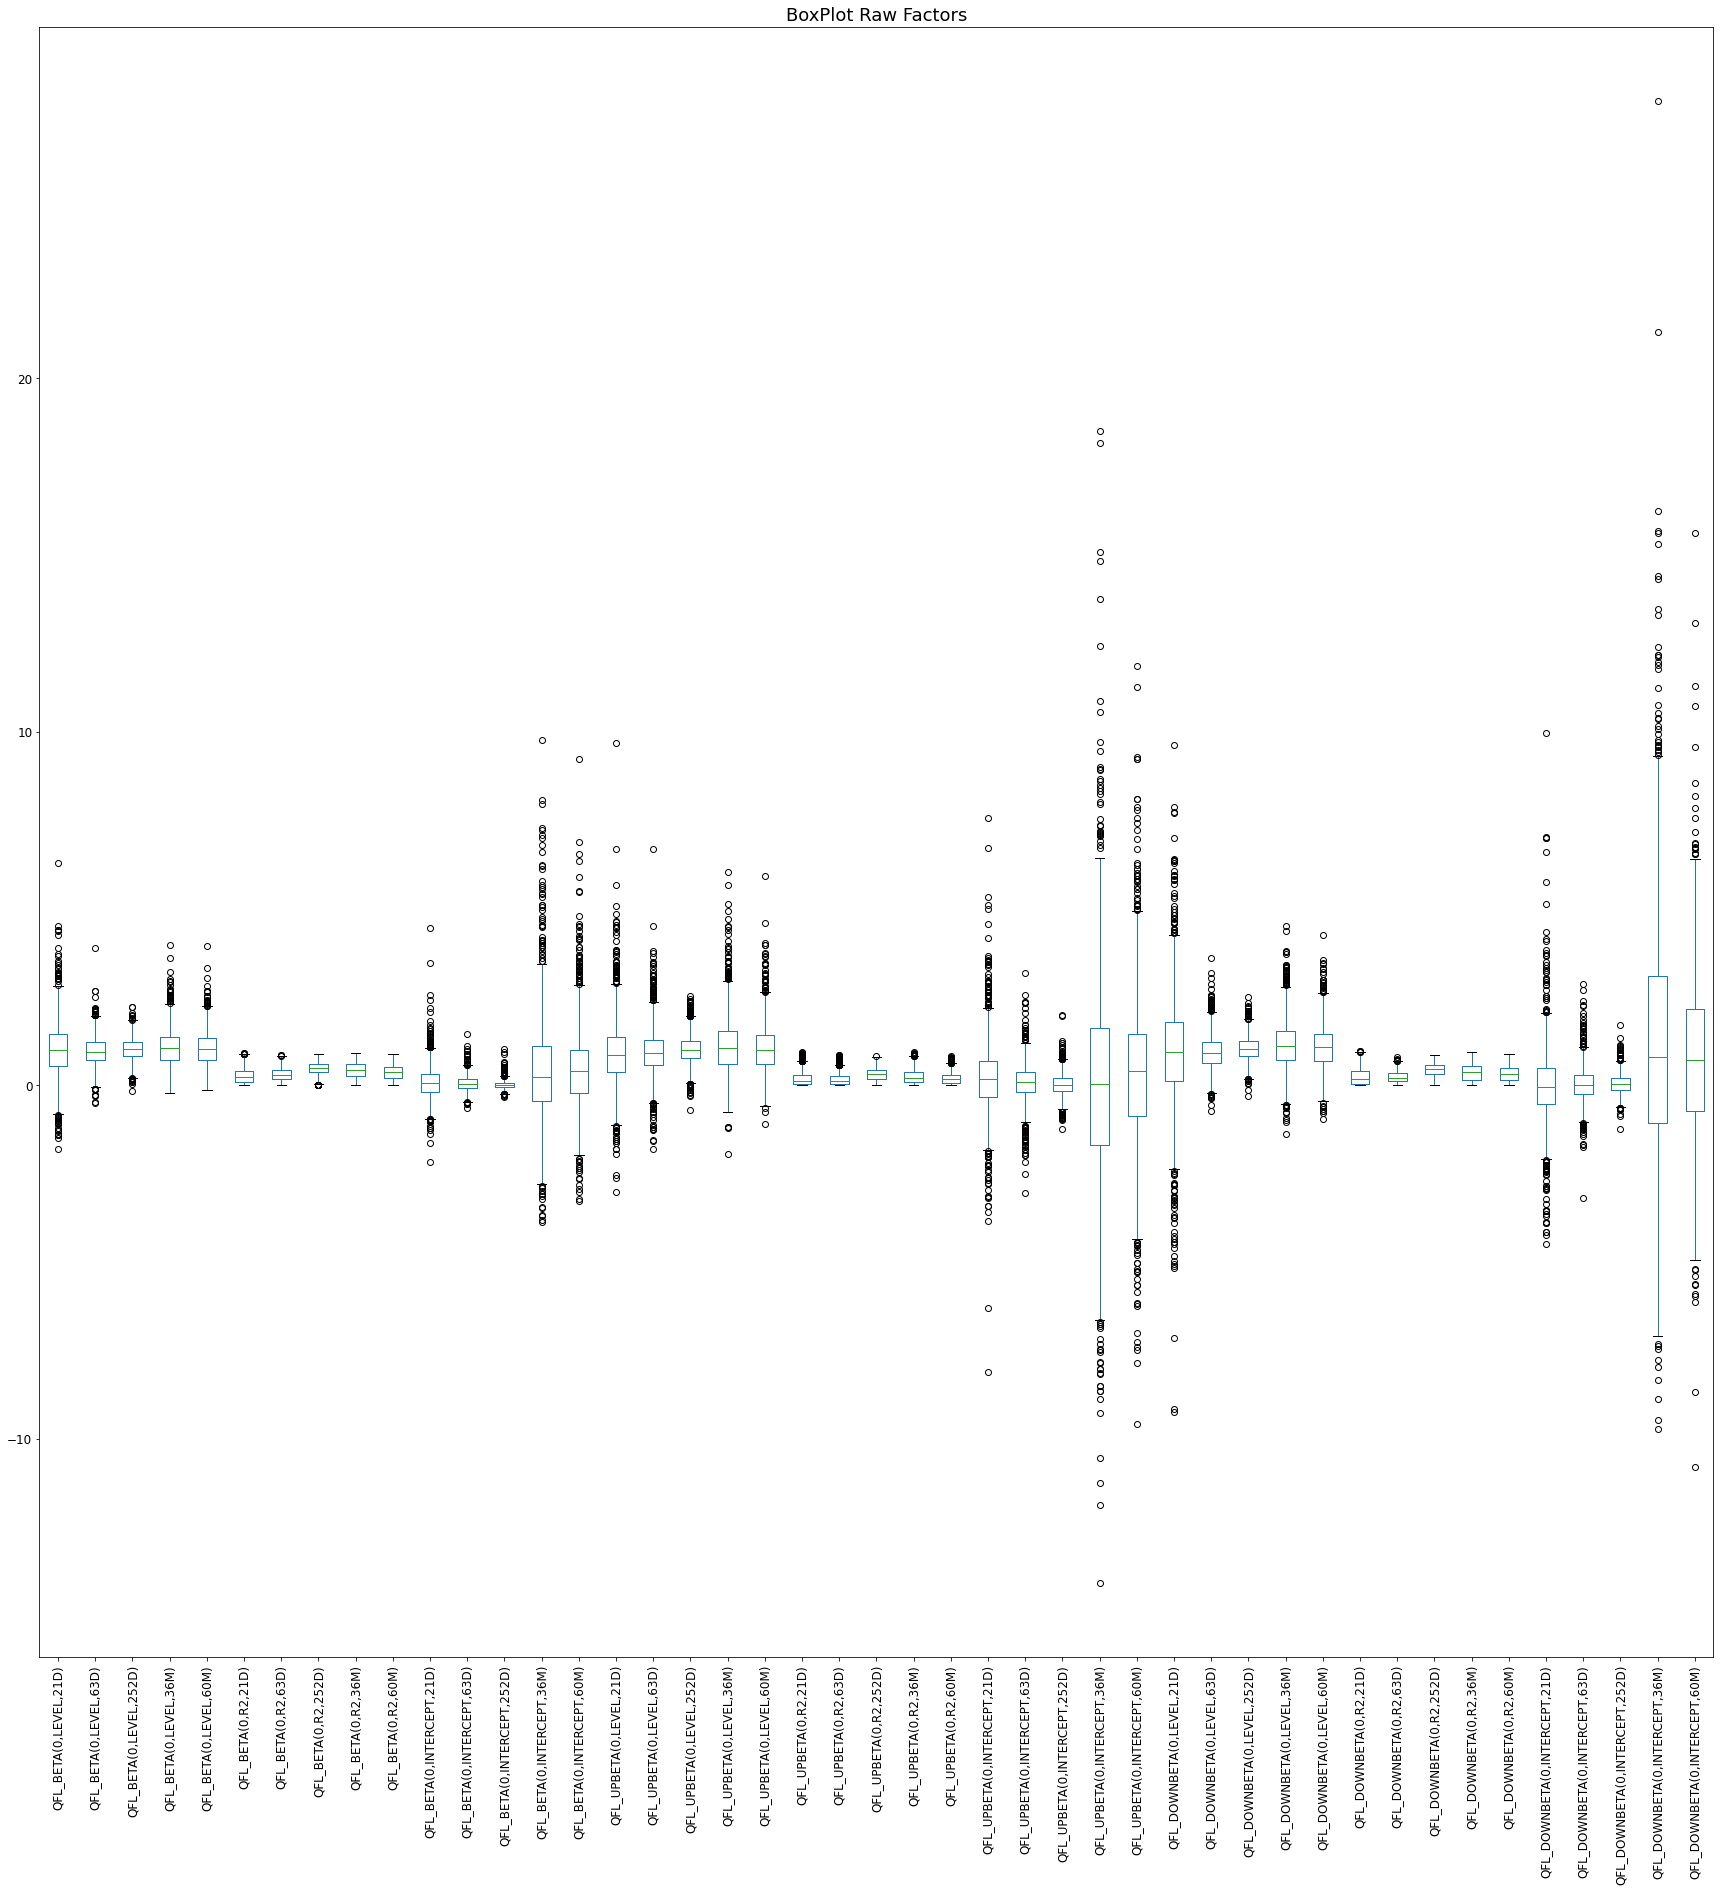

In [17]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [18]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,"QFL_BETA(0,LEVEL,21D)","QFL_BETA(0,LEVEL,63D)","QFL_BETA(0,LEVEL,252D)","QFL_BETA(0,LEVEL,36M)","QFL_BETA(0,LEVEL,60M)","QFL_BETA(0,R2,21D)","QFL_BETA(0,R2,63D)","QFL_BETA(0,R2,252D)","QFL_BETA(0,R2,36M)","QFL_BETA(0,R2,60M)","QFL_BETA(0,INTERCEPT,21D)","QFL_BETA(0,INTERCEPT,63D)","QFL_BETA(0,INTERCEPT,252D)","QFL_BETA(0,INTERCEPT,36M)","QFL_BETA(0,INTERCEPT,60M)","QFL_UPBETA(0,LEVEL,21D)","QFL_UPBETA(0,LEVEL,63D)","QFL_UPBETA(0,LEVEL,252D)","QFL_UPBETA(0,LEVEL,36M)","QFL_UPBETA(0,LEVEL,60M)","QFL_UPBETA(0,R2,21D)","QFL_UPBETA(0,R2,63D)","QFL_UPBETA(0,R2,252D)","QFL_UPBETA(0,R2,36M)","QFL_UPBETA(0,R2,60M)","QFL_UPBETA(0,INTERCEPT,21D)","QFL_UPBETA(0,INTERCEPT,63D)","QFL_UPBETA(0,INTERCEPT,252D)","QFL_UPBETA(0,INTERCEPT,36M)","QFL_UPBETA(0,INTERCEPT,60M)","QFL_DOWNBETA(0,LEVEL,21D)","QFL_DOWNBETA(0,LEVEL,63D)","QFL_DOWNBETA(0,LEVEL,252D)","QFL_DOWNBETA(0,LEVEL,36M)","QFL_DOWNBETA(0,LEVEL,60M)","QFL_DOWNBETA(0,R2,21D)","QFL_DOWNBETA(0,R2,63D)","QFL_DOWNBETA(0,R2,252D)","QFL_DOWNBETA(0,R2,36M)","QFL_DOWNBETA(0,R2,60M)","QFL_DOWNBETA(0,INTERCEPT,21D)","QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)","QFL_DOWNBETA(0,INTERCEPT,60M)"
count,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03
mean,7.305379e-16,9.625759e-16,-1.152100e-15,2.220374e-15,6.318098e-16,-2.546327e-15,-1.470924e-15,-3.302286e-15,1.761182e-15,-3.596332e-16,-2.110674e-16,3.714656e-16,1.591413e-16,-5.386479e-16,-3.658540e-16,-3.340396e-16,-2.162083e-15,3.155907e-15,-7.680653e-17,2.058048e-15,1.264390e-15,-4.985569e-16,-2.963082e-15,3.944262e-15,-3.701719e-16,3.491723e-16,-2.936074e-16,1.061407e-16,2.097327e-17,1.735307e-16,-6.454995e-16,-8.689095e-16,-1.527115e-15,-1.103351e-15,-2.494599e-15,1.553895e-15,-2.108693e-15,2.522828e-15,-1.033059e-15,3.815888e-16,8.184247e-17,-7.735388e-17,-1.923364e-16,-1.385810e-16,-6.692076e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.595864e+00,-3.488503e+00,-3.673784e+00,-2.539616e+00,-2.489372e+00,-1.268750e+00,-1.791903e+00,-2.737886e+00,-1.985503e+00,-1.893258e+00,-4.901987e+00,-3.280209e+00,-3.013510e+00,-2.946582e+00,-3.217403e+00,-4.183267e+00,-4.072699e+00,-4.273860e+00,-3.692026e+00,-3.174296e+00,-8.878600e-01,-1.007030e+00,-1.827499e+00,-1.233305e+00,-1.232171e+00,-8.072209e+00,-5.830038e+00,-4.108485e+00,-4.734779e+00,-4.627134e+00,-6.247054e+00,-3.573818e+00,-3.959950e+00,-3.455902e+00,-3.265293e+00,-1.018548e+00,-1.481871e+00,-2.548007e+00,-1.554757e+00,-1.557407e+00,-4.146541e+00,-6.743718e+00,-4.681459e+00,-3.065297e+00,-4.952160e+00
25%,-5.996637e-01,-6.275869e-01,-6.260336e-01,-6.746701e-01,-6.577042e-01,-8.261985e-01,-7.510935e-01,-6.283652e-01,-7.849392e-01,-8.011371e-01,-5.971261e-01,-6.620814e-01,-6.000804e-01,-5.884012e-01,-5.928843e-01,-5.724637e-01,-5.547626e-01,-6.025911e-01,-6.316038e-01,-6.520888e-01,-7.572344e-01,-7.602662e-01,-7.679660e-01,-8.483301e-01,-8.183031e-01,-5.104181e-01,-5.3421

In [19]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,"QFL_BETA(0,LEVEL,21D)","QFL_BETA(0,LEVEL,63D)","QFL_BETA(0,LEVEL,252D)","QFL_BETA(0,LEVEL,36M)","QFL_BETA(0,LEVEL,60M)","QFL_BETA(0,R2,21D)","QFL_BETA(0,R2,63D)","QFL_BETA(0,R2,252D)","QFL_BETA(0,R2,36M)","QFL_BETA(0,R2,60M)","QFL_BETA(0,INTERCEPT,21D)","QFL_BETA(0,INTERCEPT,63D)","QFL_BETA(0,INTERCEPT,252D)","QFL_BETA(0,INTERCEPT,36M)","QFL_BETA(0,INTERCEPT,60M)","QFL_UPBETA(0,LEVEL,21D)","QFL_UPBETA(0,LEVEL,63D)","QFL_UPBETA(0,LEVEL,252D)","QFL_UPBETA(0,LEVEL,36M)","QFL_UPBETA(0,LEVEL,60M)","QFL_UPBETA(0,R2,21D)","QFL_UPBETA(0,R2,63D)","QFL_UPBETA(0,R2,252D)","QFL_UPBETA(0,R2,36M)","QFL_UPBETA(0,R2,60M)","QFL_UPBETA(0,INTERCEPT,21D)","QFL_UPBETA(0,INTERCEPT,63D)","QFL_UPBETA(0,INTERCEPT,252D)","QFL_UPBETA(0,INTERCEPT,36M)","QFL_UPBETA(0,INTERCEPT,60M)","QFL_DOWNBETA(0,LEVEL,21D)","QFL_DOWNBETA(0,LEVEL,63D)","QFL_DOWNBETA(0,LEVEL,252D)","QFL_DOWNBETA(0,LEVEL,36M)","QFL_DOWNBETA(0,LEVEL,60M)","QFL_DOWNBETA(0,R2,21D)","QFL_DOWNBETA(0,R2,63D)","QFL_DOWNBETA(0,R2,252D)","QFL_DOWNBETA(0,R2,36M)","QFL_DOWNBETA(0,R2,60M)","QFL_DOWNBETA(0,INTERCEPT,21D)","QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)","QFL_DOWNBETA(0,INTERCEPT,60M)"
0,6.746277,6.919673,3.713037,5.849865,6.135531,2.982556,3.028538,2.406539,2.280719,2.650304,9.485813,6.637449,8.225879,6.463120,7.549003,9.275031,8.476746,3.779427,5.918305,7.178201,3.359926,3.826638,2.971822,3.353725,3.868348,7.158491,5.712813,6.288074,6.182491,5.353688,5.349709,5.643399,4.326258,4.591409,5.063517,2.991783,3.705418,2.369997,2.519369,2.708911,9.238141,6.029660,6.136165,7.516293,6.354450
1,4.457719,4.065458,3.696309,5.114245,4.819648,2.961118,2.930939,2.352943,2.264742,2.461283,7.333979,5.016464,7.653537,5.301013,5.518922,6.114123,5.242015,3.575387,5.497185,5.201224,3.282617,3.798316,2.872075,3.277963,3.703432,6.334920,4.573578,6.230337,6.067886,5.084259,4.269694,4.732126,3.851720,4.396605,3.939286,2.916270,3.256932,2.301676,2.467426,2.689511,6.503309,5.659575,4.757637,5.673827,5.259068
2,4.331494,4.058019,3.128694,4.292456,4.211698,2.931648,2.830668,2.233771,2.220860,2.417435,5.348809,4.533346,7.075375,5.207117,5.225234,5.015290,4.203745,3.480220,4.853102,4.397158,3.255825,3.777034,2.834068,3.122263,3.555814,4.973863,4.202409,3.981512,5.036298,4.155346,4.187525,4.449081,3.569571,3.638891,3.817949,2.881559,3.107633,2.283679,2.381524,2.687937,6.488149,4.985705,4.012012,4.249890,4.493423
3,4.306638,3.626825,2.970159,3.925560,3.729423,2.928006,2.798897,2.185769,2.198705,2.361535,5.035088,4.327019,5.242505,4.740638,5.061880,4.403364,4.124161,3.445791,4.591633,4.309110,3.238733,3.684159,2.533509,3.097444,3.482537,4.773459,4.189097,3.766493,4.947372,4.136637,4.161960,4.095706,3.489828,3.597588,3.730370,2.875522,3.091515,2.260057,2.361554,2.662693,6.476398,4.781114,3.901193,4.092218,4.255084
4,4.270245,2.862848,2.887215,3.781417,3.414044,2.915172,2.767899,2.061681,2.159604,2.339621,4.557621,3.934845,5.026367,4.699090,4.667861,4.145997,3.941545,3.400436,4.333140,4.285925,3.216271,3.560300,2.455165,2.988728,3.439532,4.651378,4.182202,3.750586,4.594101,4.133550,3.734707,3.766923,3.421364,3.596150,3.549809,2.825836,2.965330,2.239652,2.355196,2.518859,6.115554,4.727042,3.856258,4.072269,3.756755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,-3.105708,-3.488503,NaN,NaN,NaN,-1.268689,-1.791903,NaN,NaN,NaN,-3.201423,-3.280209,NaN,NaN,NaN,-3.655148,-4.072699,NaN,NaN,NaN,-0.887842,-1.007030,NaN,NaN,NaN,-3.929348,-5.830038,NaN,NaN,NaN,-4.958483,-3.573818,NaN,NaN,NaN,-1.018544,-1.481871,NaN,NaN,NaN,-3.833761,-6.743718,NaN,NaN,NaN
1596,-3.184824,NaN,NaN,NaN,NaN,-1.268731,NaN,NaN,NaN,NaN,-3.725000,NaN,NaN,NaN,NaN,-3.757794,NaN,NaN,NaN,NaN,-0.887846,NaN,NaN,NaN,NaN,-6.311482,NaN,NaN,NaN,NaN,-6.194411,NaN,NaN,NaN,NaN,-1.018544,NaN,NaN,NaN,NaN,-3.908899,NaN,NaN,NaN,NaN
1597,-3.595864,NaN,NaN,NaN,NaN,-1.268750,NaN,NaN,NaN,N

In [20]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,"QFL_BETA(0,LEVEL,21D)","QFL_BETA(0,LEVEL,63D)","QFL_BETA(0,LEVEL,252D)","QFL_BETA(0,LEVEL,36M)","QFL_BETA(0,LEVEL,60M)","QFL_BETA(0,R2,21D)","QFL_BETA(0,R2,63D)","QFL_BETA(0,R2,252D)","QFL_BETA(0,R2,36M)","QFL_BETA(0,R2,60M)","QFL_BETA(0,INTERCEPT,21D)","QFL_BETA(0,INTERCEPT,63D)","QFL_BETA(0,INTERCEPT,252D)","QFL_BETA(0,INTERCEPT,36M)","QFL_BETA(0,INTERCEPT,60M)","QFL_UPBETA(0,LEVEL,21D)","QFL_UPBETA(0,LEVEL,63D)","QFL_UPBETA(0,LEVEL,252D)","QFL_UPBETA(0,LEVEL,36M)","QFL_UPBETA(0,LEVEL,60M)","QFL_UPBETA(0,R2,21D)","QFL_UPBETA(0,R2,63D)","QFL_UPBETA(0,R2,252D)","QFL_UPBETA(0,R2,36M)","QFL_UPBETA(0,R2,60M)","QFL_UPBETA(0,INTERCEPT,21D)","QFL_UPBETA(0,INTERCEPT,63D)","QFL_UPBETA(0,INTERCEPT,252D)","QFL_UPBETA(0,INTERCEPT,36M)","QFL_UPBETA(0,INTERCEPT,60M)","QFL_DOWNBETA(0,LEVEL,21D)","QFL_DOWNBETA(0,LEVEL,63D)","QFL_DOWNBETA(0,LEVEL,252D)","QFL_DOWNBETA(0,LEVEL,36M)","QFL_DOWNBETA(0,LEVEL,60M)","QFL_DOWNBETA(0,R2,21D)","QFL_DOWNBETA(0,R2,63D)","QFL_DOWNBETA(0,R2,252D)","QFL_DOWNBETA(0,R2,36M)","QFL_DOWNBETA(0,R2,60M)","QFL_DOWNBETA(0,INTERCEPT,21D)","QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)","QFL_DOWNBETA(0,INTERCEPT,60M)"
0,-3.595864,-3.488503,-3.673784,-2.539616,-2.489372,-1.268750,-1.791903,-2.737886,-1.985503,-1.893258,-4.901987,-3.280209,-3.013510,-2.946582,-3.217403,-4.183267,-4.072699,-4.273860,-3.692026,-3.174296,-0.887860,-1.007030,-1.827499,-1.233305,-1.232171,-8.072209,-5.830038,-4.108485,-4.734779,-4.627134,-6.247054,-3.573818,-3.959950,-3.455902,-3.265293,-1.018548,-1.481871,-2.548007,-1.554757,-1.557407,-4.146541,-6.743718,-4.681459,-3.065297,-4.952160
1,-3.184824,-3.444151,-3.058368,-2.523139,-2.472033,-1.268731,-1.791886,-2.726017,-1.985456,-1.891688,-3.725000,-2.842708,-2.689207,-2.911418,-3.188360,-3.757794,-3.714518,-3.285551,-2.816601,-2.675668,-0.887846,-1.007030,-1.827482,-1.233305,-1.232159,-6.311482,-4.842626,-3.272590,-3.995825,-3.820469,-6.194411,-3.169177,-3.504447,-2.999310,-2.976509,-1.018544,-1.481291,-2.543535,-1.554757,-1.557388,-3.908899,-3.738143,-3.306074,-2.993856,-4.040255
2,-3.105708,-3.003923,-2.933162,-2.512282,-2.460001,-1.268689,-1.791886,-2.717450,-1.985371,-1.890624,-3.201423,-2.748853,-2.565155,-2.832192,-3.012387,-3.655148,-3.701336,-3.246463,-2.778921,-2.514023,-0.887842,-1.007024,-1.826799,-1.233290,-1.232152,-3.929348,-4.175046,-3.150970,-3.782569,-3.657883,-4.958483,-2.755911,-2.995481,-2.937247,-2.924728,-1.018544,-1.480360,-2.536388,-1.554757,-1.557373,-3.833761,-3.624441,-3.134895,-2.822161,-2.958565
3,-3.092665,-2.941515,-2.911220,-2.461736,-2.450780,-1.268680,-1.791780,-2.713557,-1.983645,-1.890299,-2.899017,-2.659098,-2.282096,-2.816171,-2.938206,-3.031912,-3.250632,-3.129035,-2.762932,-2.430643,-0.887837,-1.007019,-1.826546,-1.233290,-1.232152,-3.692157,-3.832662,-3.140802,-3.547097,-3.614834,-3.741616,-2.746241,-2.919811,-2.832248,-2.884826,-1.018536,-1.480258,-2.530563,-1.554753,-1.557359,-3.813950,-3.531001,-2.692177,-2.671911,-2.883135
4,-3.054035,-2.926409,-2.799592,-2.420640,-2.414911,-1.268680,-1.791769,-2.679714,-1.983358,-1.889055,-2.815866,-2.592555,-2.186190,-2.672611,-2.841335,-2.900478,-3.238810,-3.000315,-2.265313,-2.269949,-0.887819,-1.006973,-1.826093,-1.233256,-1.232146,-3.520189,-3.821693,-3.105389,-3.118807,-3.554178,-3.700411,-2.714098,-2.767088,-2.650921,-2.801251,-1.018532,-1.480187,-2.511277,-1.554706,-1.557093,-3.598033,-3.056002,-2.657336,-2.565458,-2.864309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,4.331494,6.919673,NaN,NaN,NaN,2.931648,3.028538,NaN,NaN,NaN,5.348809,6.637449,NaN,NaN,NaN,5.015290,8.476746,NaN,NaN,NaN,3.255825,3.826638,NaN,NaN,NaN,4.973863,5.712813,NaN,NaN,NaN,4.187525,5.643399,NaN,NaN,NaN,2.881559,3.705418,NaN,NaN,NaN,6.488149,6.029660,NaN,NaN,NaN
1596,4.457719,NaN,NaN,NaN,NaN,2.961118,NaN,NaN,NaN,NaN,7.333979,NaN,NaN,NaN,NaN,6.1141

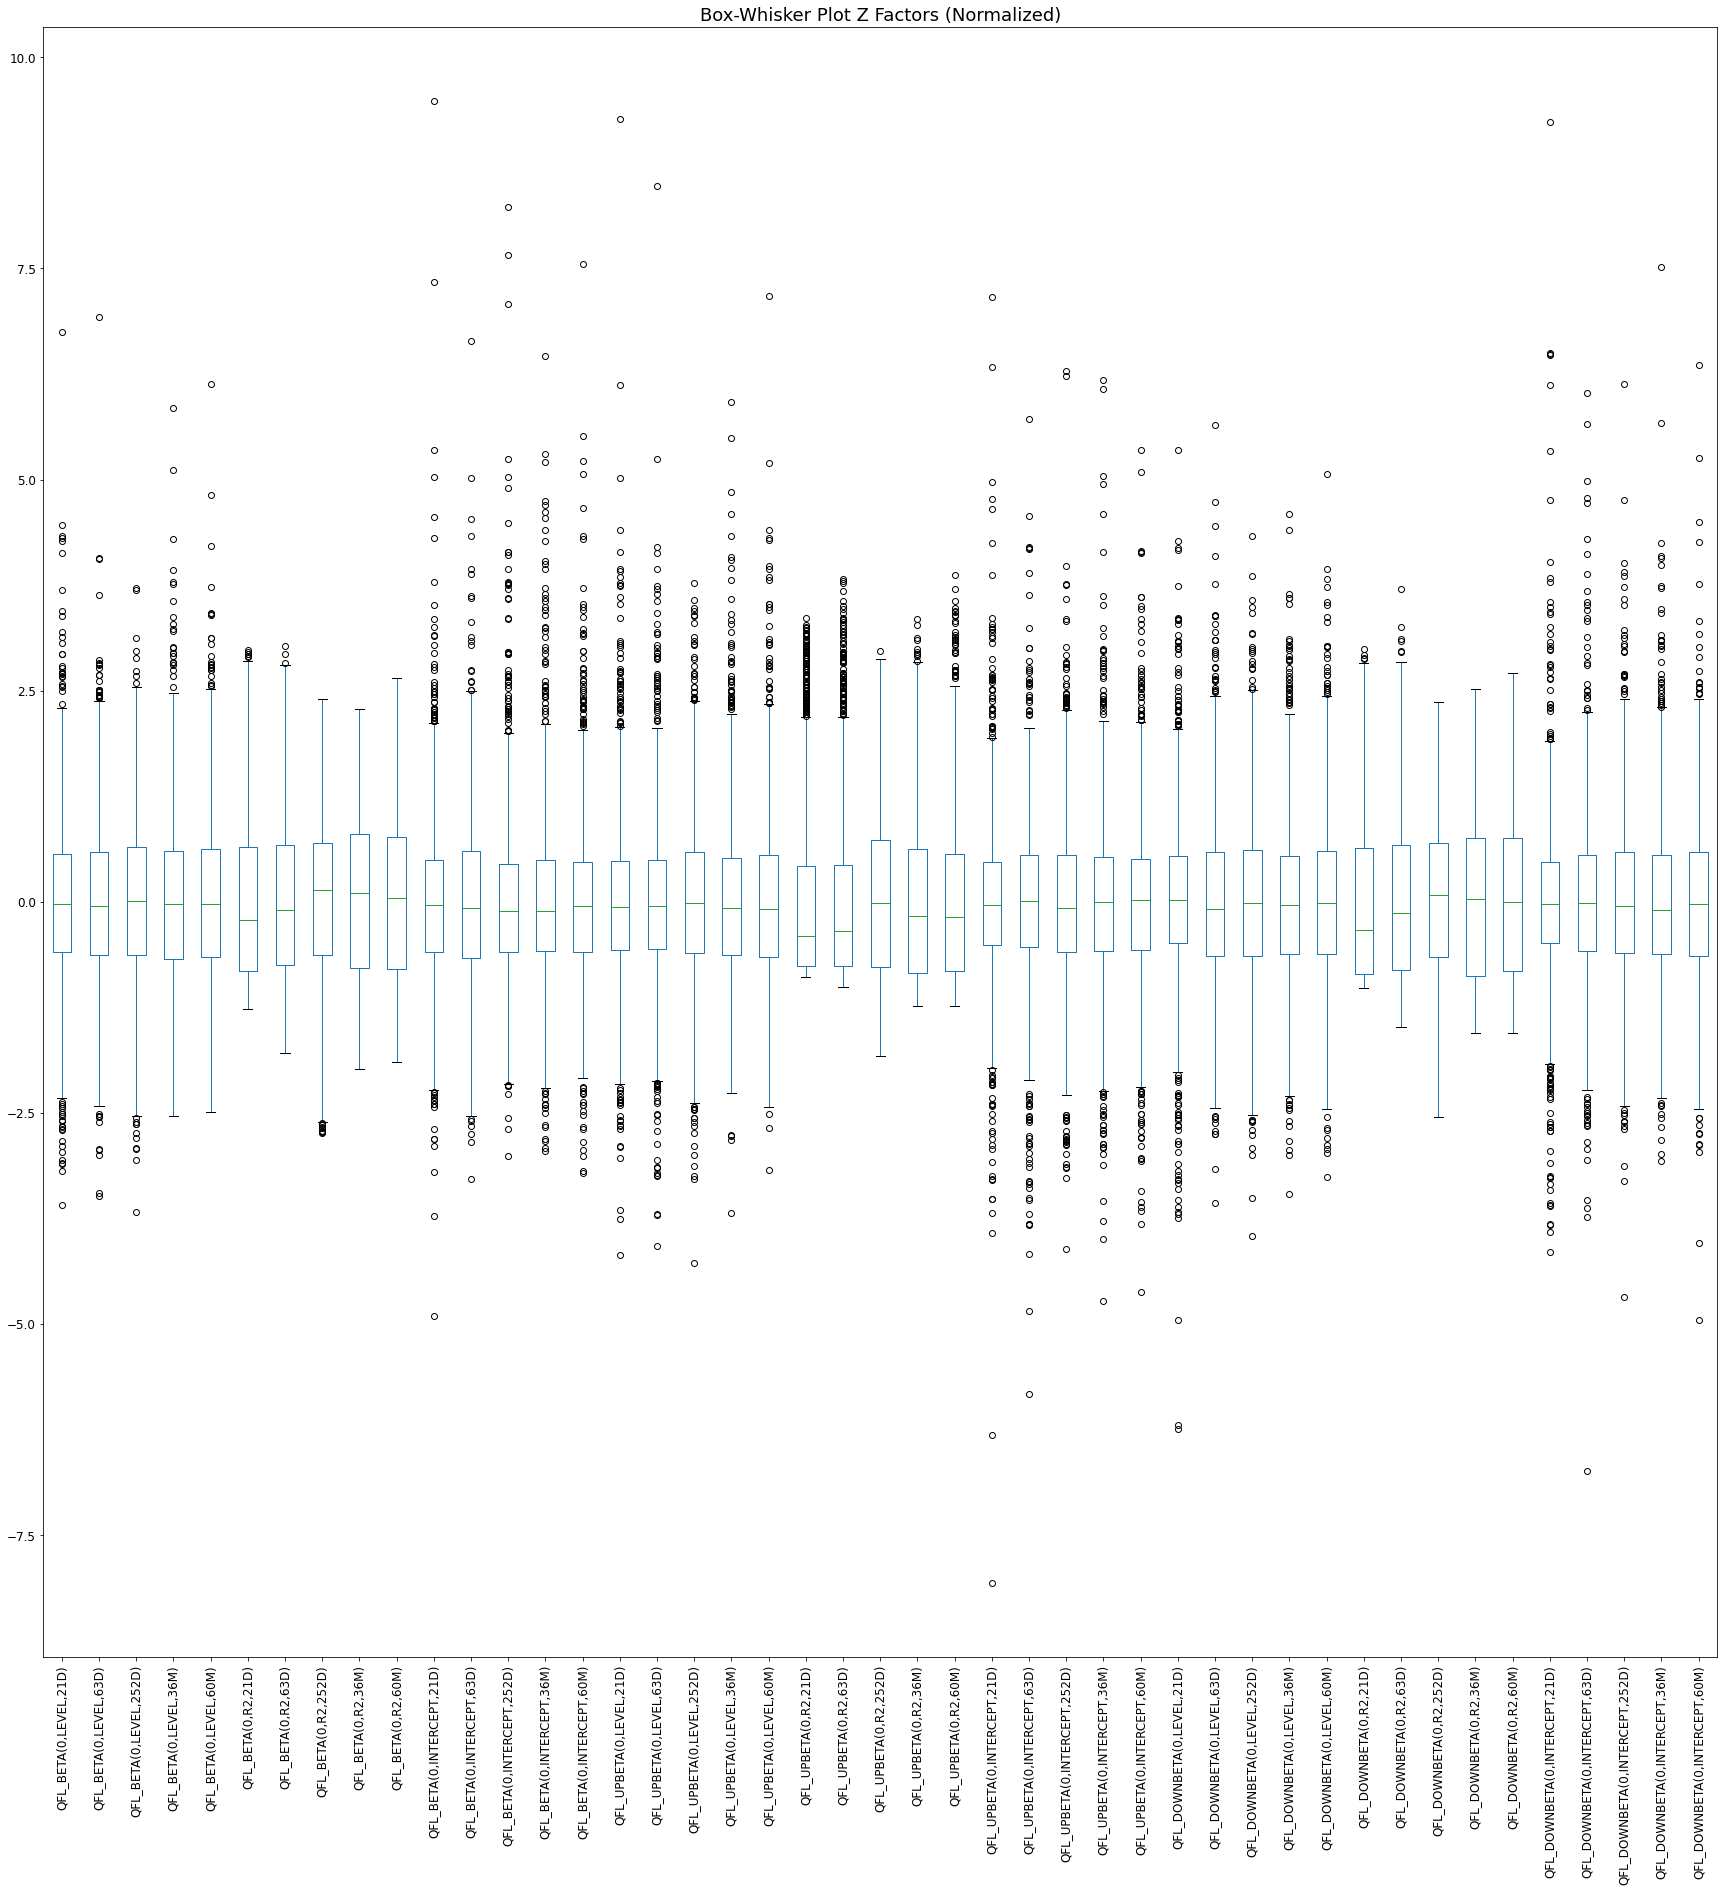

In [21]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [22]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,"QFL_BETA(0,LEVEL,21D)","QFL_BETA(0,LEVEL,63D)","QFL_BETA(0,LEVEL,252D)","QFL_BETA(0,LEVEL,36M)","QFL_BETA(0,LEVEL,60M)","QFL_BETA(0,R2,21D)","QFL_BETA(0,R2,63D)","QFL_BETA(0,R2,252D)","QFL_BETA(0,R2,36M)","QFL_BETA(0,R2,60M)","QFL_BETA(0,INTERCEPT,21D)","QFL_BETA(0,INTERCEPT,63D)","QFL_BETA(0,INTERCEPT,252D)","QFL_BETA(0,INTERCEPT,36M)","QFL_BETA(0,INTERCEPT,60M)","QFL_UPBETA(0,LEVEL,21D)","QFL_UPBETA(0,LEVEL,63D)","QFL_UPBETA(0,LEVEL,252D)","QFL_UPBETA(0,LEVEL,36M)","QFL_UPBETA(0,LEVEL,60M)","QFL_UPBETA(0,R2,21D)","QFL_UPBETA(0,R2,63D)","QFL_UPBETA(0,R2,252D)","QFL_UPBETA(0,R2,36M)","QFL_UPBETA(0,R2,60M)","QFL_UPBETA(0,INTERCEPT,21D)","QFL_UPBETA(0,INTERCEPT,63D)","QFL_UPBETA(0,INTERCEPT,252D)","QFL_UPBETA(0,INTERCEPT,36M)","QFL_UPBETA(0,INTERCEPT,60M)","QFL_DOWNBETA(0,LEVEL,21D)","QFL_DOWNBETA(0,LEVEL,63D)","QFL_DOWNBETA(0,LEVEL,252D)","QFL_DOWNBETA(0,LEVEL,36M)","QFL_DOWNBETA(0,LEVEL,60M)","QFL_DOWNBETA(0,R2,21D)","QFL_DOWNBETA(0,R2,63D)","QFL_DOWNBETA(0,R2,252D)","QFL_DOWNBETA(0,R2,36M)","QFL_DOWNBETA(0,R2,60M)","QFL_DOWNBETA(0,INTERCEPT,21D)","QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)","QFL_DOWNBETA(0,INTERCEPT,60M)",MFR
0,-3.595864,-3.488503,-3.673784,-2.539616,-2.489372,-1.268750,-1.791903,-2.737886,-1.985503,-1.893258,-4.901987,-3.280209,-3.013510,-2.946582,-3.217403,-4.183267,-4.072699,-4.273860,-3.692026,-3.174296,-0.887860,-1.007030,-1.827499,-1.233305,-1.232171,-8.072209,-5.830038,-4.108485,-4.734779,-4.627134,-6.247054,-3.573818,-3.959950,-3.455902,-3.265293,-1.018548,-1.481871,-2.548007,-1.554757,-1.557407,-4.146541,-6.743718,-4.681459,-3.065297,-4.952160,-3.289613
1,-3.184824,-3.444151,-3.058368,-2.523139,-2.472033,-1.268731,-1.791886,-2.726017,-1.985456,-1.891688,-3.725000,-2.842708,-2.689207,-2.911418,-3.188360,-3.757794,-3.714518,-3.285551,-2.816601,-2.675668,-0.887846,-1.007030,-1.827482,-1.233305,-1.232159,-6.311482,-4.842626,-3.272590,-3.995825,-3.820469,-6.194411,-3.169177,-3.504447,-2.999310,-2.976509,-1.018544,-1.481291,-2.543535,-1.554757,-1.557388,-3.908899,-3.738143,-3.306074,-2.993856,-4.040255,-2.874901
2,-3.105708,-3.003923,-2.933162,-2.512282,-2.460001,-1.268689,-1.791886,-2.717450,-1.985371,-1.890624,-3.201423,-2.748853,-2.565155,-2.832192,-3.012387,-3.655148,-3.701336,-3.246463,-2.778921,-2.514023,-0.887842,-1.007024,-1.826799,-1.233290,-1.232152,-3.929348,-4.175046,-3.150970,-3.782569,-3.657883,-4.958483,-2.755911,-2.995481,-2.937247,-2.924728,-1.018544,-1.480360,-2.536388,-1.554757,-1.557373,-3.833761,-3.624441,-3.134895,-2.822161,-2.958565,-2.664467
3,-3.092665,-2.941515,-2.911220,-2.461736,-2.450780,-1.268680,-1.791780,-2.713557,-1.983645,-1.890299,-2.899017,-2.659098,-2.282096,-2.816171,-2.938206,-3.031912,-3.250632,-3.129035,-2.762932,-2.430643,-0.887837,-1.007019,-1.826546,-1.233290,-1.232152,-3.692157,-3.832662,-3.140802,-3.547097,-3.614834,-3.741616,-2.746241,-2.919811,-2.832248,-2.884826,-1.018536,-1.480258,-2.530563,-1.554753,-1.557359,-3.813950,-3.531001,-2.692177,-2.671911,-2.883135,-2.546187
4,-3.054035,-2.926409,-2.799592,-2.420640,-2.414911,-1.268680,-1.791769,-2.679714,-1.983358,-1.889055,-2.815866,-2.592555,-2.186190,-2.672611,-2.841335,-2.900478,-3.238810,-3.000315,-2.265313,-2.269949,-0.887819,-1.006973,-1.826093,-1.233256,-1.232146,-3.520189,-3.821693,-3.105389,-3.118807,-3.554178,-3.700411,-2.714098,-2.767088,-2.650921,-2.801251,-1.018532,-1.480187,-2.511277,-1.554706,-1.557093,-3.598033,-3.056002,-2.657336,-2.565458,-2.864309,-2.462552


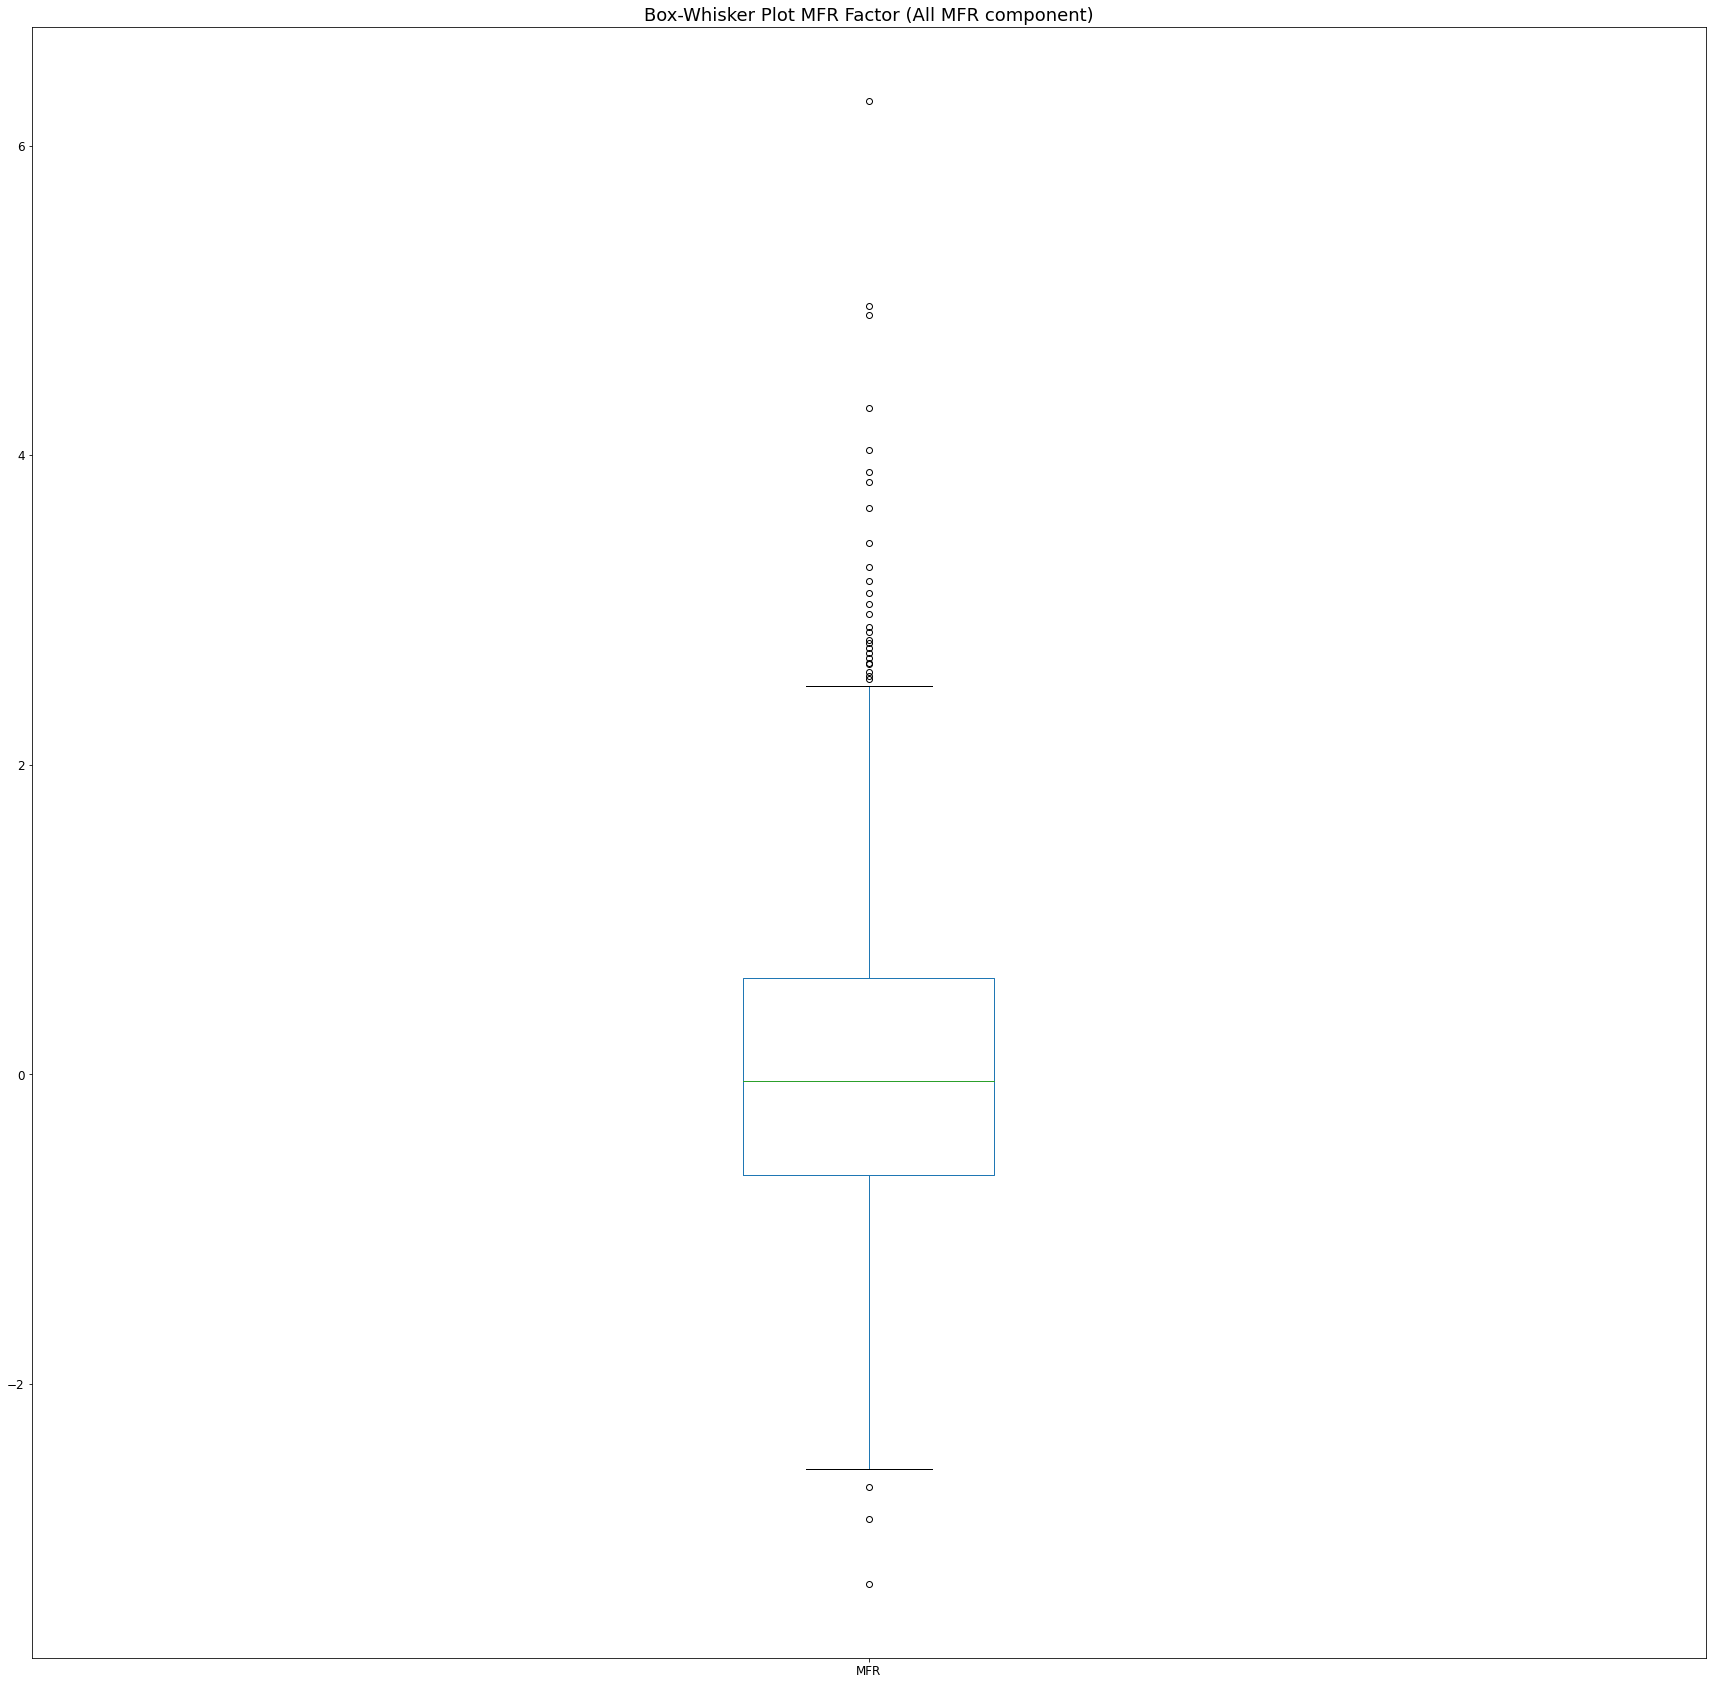

In [23]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

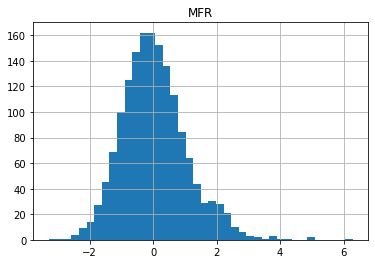

In [24]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [25]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


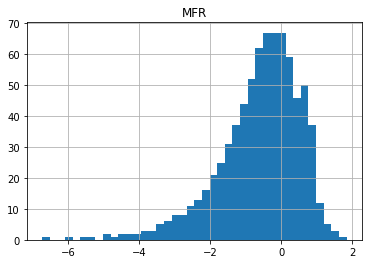

In [26]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [27]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,"QFL_BETA(0,LEVEL,21D)","QFL_BETA(0,LEVEL,63D)","QFL_BETA(0,LEVEL,252D)","QFL_BETA(0,LEVEL,36M)","QFL_BETA(0,LEVEL,60M)","QFL_BETA(0,R2,21D)","QFL_BETA(0,R2,63D)","QFL_BETA(0,R2,252D)","QFL_BETA(0,R2,36M)","QFL_BETA(0,R2,60M)","QFL_BETA(0,INTERCEPT,21D)","QFL_BETA(0,INTERCEPT,63D)","QFL_BETA(0,INTERCEPT,252D)","QFL_BETA(0,INTERCEPT,36M)","QFL_BETA(0,INTERCEPT,60M)","QFL_UPBETA(0,LEVEL,21D)","QFL_UPBETA(0,LEVEL,63D)","QFL_UPBETA(0,LEVEL,252D)","QFL_UPBETA(0,LEVEL,36M)","QFL_UPBETA(0,LEVEL,60M)","QFL_UPBETA(0,R2,21D)","QFL_UPBETA(0,R2,63D)","QFL_UPBETA(0,R2,252D)","QFL_UPBETA(0,R2,36M)","QFL_UPBETA(0,R2,60M)","QFL_UPBETA(0,INTERCEPT,21D)","QFL_UPBETA(0,INTERCEPT,63D)","QFL_UPBETA(0,INTERCEPT,252D)","QFL_UPBETA(0,INTERCEPT,36M)","QFL_UPBETA(0,INTERCEPT,60M)","QFL_DOWNBETA(0,LEVEL,21D)","QFL_DOWNBETA(0,LEVEL,63D)","QFL_DOWNBETA(0,LEVEL,252D)","QFL_DOWNBETA(0,LEVEL,36M)","QFL_DOWNBETA(0,LEVEL,60M)","QFL_DOWNBETA(0,R2,21D)","QFL_DOWNBETA(0,R2,63D)","QFL_DOWNBETA(0,R2,252D)","QFL_DOWNBETA(0,R2,36M)","QFL_DOWNBETA(0,R2,60M)","QFL_DOWNBETA(0,INTERCEPT,21D)","QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)","QFL_DOWNBETA(0,INTERCEPT,60M)"
0,0.861591,1.610198,1.118509,1.302228,1.346245,0.244189,-0.471262,-0.360094,-0.706761,-0.828156,0.025345,-0.160741,0.182982,2.127070,1.485300,1.563566,2.037778,1.107488,1.104269,1.464730,0.284010,0.442904,-0.641219,0.138878,0.217026,-0.950105,-0.780763,0.215011,3.217354,1.149191,0.890417,1.896566,1.103299,1.027167,1.155172,-1.986622,-0.631311,-0.428294,0.360123,-0.978328,0.318550,0.361035,0.119952,-0.119393,0.645002
1,1.251734,1.392137,1.124283,0.879081,0.879282,0.450638,-0.308488,-0.245935,-0.408129,-0.679994,-0.321641,-0.135252,0.088684,2.014583,1.707961,1.489957,1.349847,1.153005,0.539854,0.767634,0.315103,0.382836,-0.439242,0.206734,0.213866,-0.580456,-0.147045,0.079986,3.840337,2.410959,0.327754,1.558148,1.072252,0.483585,0.559072,-4.141939,-0.403229,-0.301638,0.220694,-1.383506,-0.715076,0.103369,-0.027884,-1.318583,-0.373123
2,0.977121,1.385195,0.683623,1.113462,1.171633,0.179004,-0.652756,-0.980691,-0.853292,-0.943158,-0.253297,-0.177563,0.210121,2.062143,1.769571,1.486608,1.762081,0.614779,1.336714,1.087001,0.153935,0.263224,-1.519360,0.272714,0.189366,-0.919348,-0.563695,0.388769,1.343956,2.453193,0.481733,1.238941,0.639716,0.512783,0.733700,-3.944495,-0.937119,-1.318131,0.048014,-2.191876,-0.306034,-0.302111,-0.004324,-1.605728,-0.928978
3,1.431287,1.344539,0.992680,1.309334,1.181302,0.321083,-0.744127,-0.577436,-0.548226,-0.838372,-0.430363,-0.143153,0.100999,0.318377,0.728503,2.222191,1.258325,0.903688,1.843832,1.475115,0.267217,0.146442,-1.133788,0.397825,0.266027,-1.432395,-0.034543,0.219383,-1.958213,-0.215105,0.214552,1.341049,1.051975,0.863571,0.850114,-4.114323,-1.001884,-0.534101,0.370470,-1.186044,-0.758130,-0.163126,0.159252,-1.707052,-0.536148
4,1.214249,1.264529,0.945652,1.075778,1.060477,0.546202,-0.433872,-0.317299,-0.493765,-0.679201,-0.190792,0.017097,0.061746,0.697114,0.573646,1.406342,0.913093,0.869954,0.951692,1.020823,0.355076,0.218818,-0.657537,0.291591,0.259901,-0.413201,0.351598,0.208426,1.159476,0.738445,0.644602,1.476014,0.951700,1.297097,1.056681,-1.943757,-0.595527,-0.343656,0.422939,-0.976471,-0.415955,0.248248,-0.013721,1.969548,0.465832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1.859705,1.022785,1.089385,1.212084,1.138804,0.151393,-1.841875,-0.698785,-0.336907,-0.565671,-0.146520,0.221638,-0.043206,-0.048561,-0.307388,2.188848,0.981199,0.803405,1.115507,1.167896,0.081743,0.032091,-1.506651,0.532579,0.446300,-0.380204,0.308286,0.310197,-0.431164,-1.342744,0.076826,0.761004,1.224969,1.654241,1.699027,-5.721437,-1.873189,-0.580665,0.778752,-0.284769,-1.430627,-0.073195,0.014579,3.147473,3.488408
1596,0.634806,0.808760,0.661598,0.732832,0.787571,0.259464,-0.961228,-1.106486

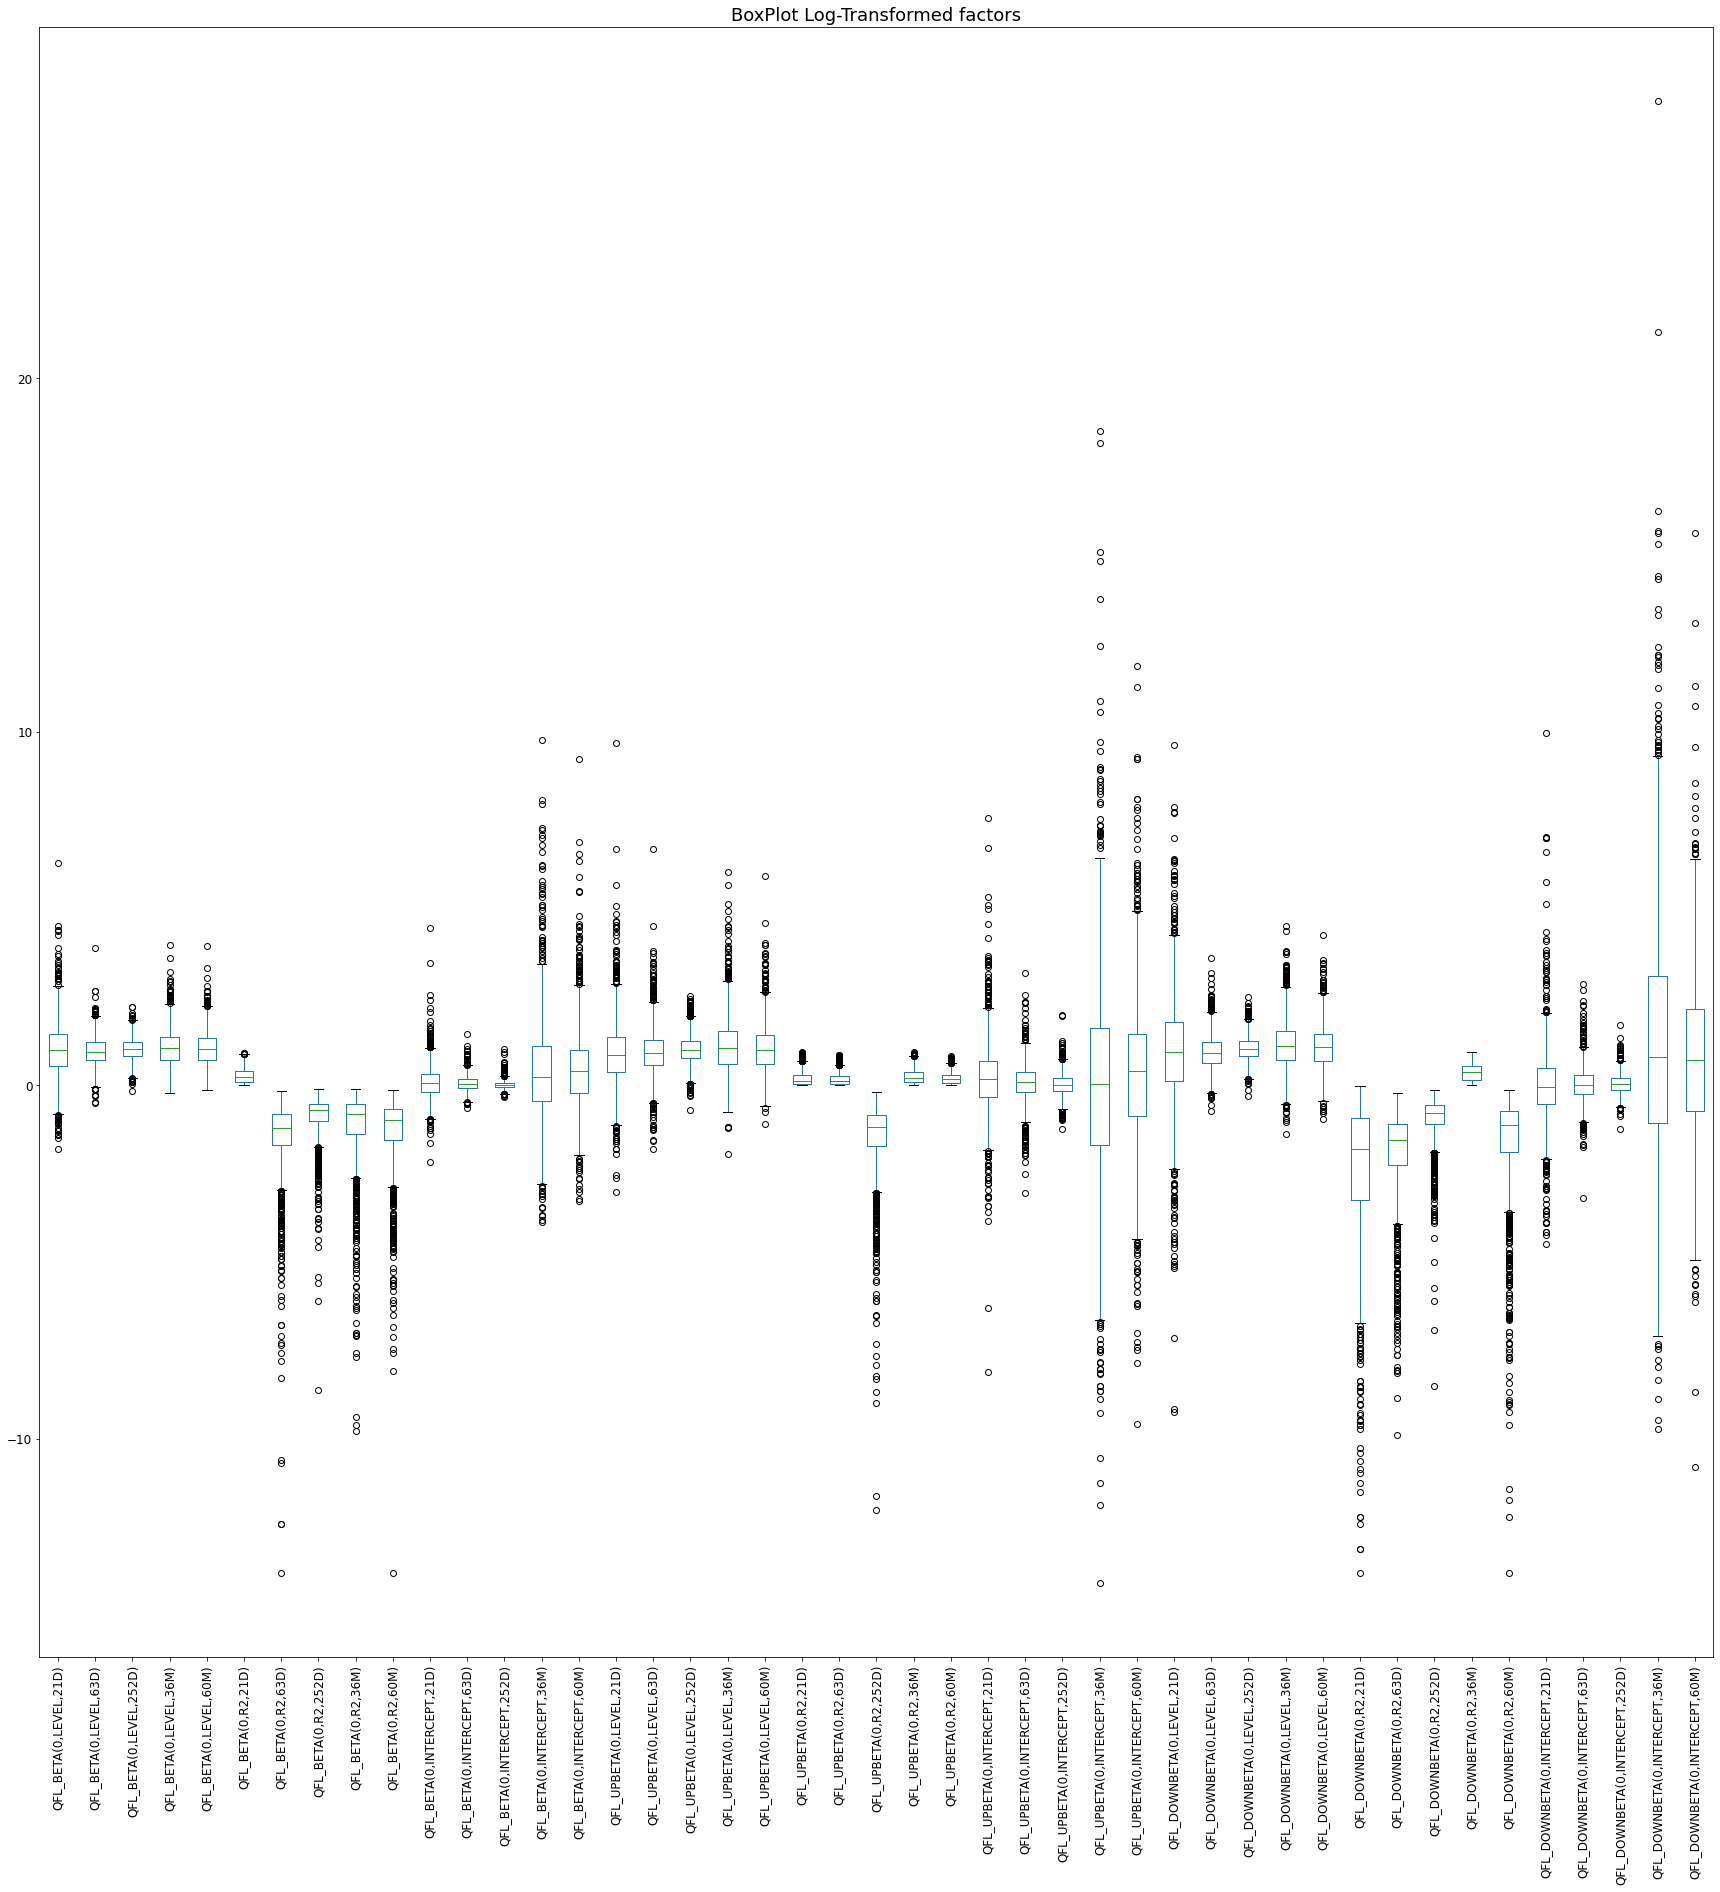

In [28]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [29]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,"QFL_BETA(0,LEVEL,21D)","QFL_BETA(0,LEVEL,63D)","QFL_BETA(0,LEVEL,252D)","QFL_BETA(0,LEVEL,36M)","QFL_BETA(0,LEVEL,60M)","QFL_BETA(0,R2,21D)","QFL_BETA(0,R2,63D)","QFL_BETA(0,R2,252D)","QFL_BETA(0,R2,36M)","QFL_BETA(0,R2,60M)","QFL_BETA(0,INTERCEPT,21D)","QFL_BETA(0,INTERCEPT,63D)","QFL_BETA(0,INTERCEPT,252D)","QFL_BETA(0,INTERCEPT,36M)","QFL_BETA(0,INTERCEPT,60M)","QFL_UPBETA(0,LEVEL,21D)","QFL_UPBETA(0,LEVEL,63D)","QFL_UPBETA(0,LEVEL,252D)","QFL_UPBETA(0,LEVEL,36M)","QFL_UPBETA(0,LEVEL,60M)","QFL_UPBETA(0,R2,21D)","QFL_UPBETA(0,R2,63D)","QFL_UPBETA(0,R2,252D)","QFL_UPBETA(0,R2,36M)","QFL_UPBETA(0,R2,60M)","QFL_UPBETA(0,INTERCEPT,21D)","QFL_UPBETA(0,INTERCEPT,63D)","QFL_UPBETA(0,INTERCEPT,252D)","QFL_UPBETA(0,INTERCEPT,36M)","QFL_UPBETA(0,INTERCEPT,60M)","QFL_DOWNBETA(0,LEVEL,21D)","QFL_DOWNBETA(0,LEVEL,63D)","QFL_DOWNBETA(0,LEVEL,252D)","QFL_DOWNBETA(0,LEVEL,36M)","QFL_DOWNBETA(0,LEVEL,60M)","QFL_DOWNBETA(0,R2,21D)","QFL_DOWNBETA(0,R2,63D)","QFL_DOWNBETA(0,R2,252D)","QFL_DOWNBETA(0,R2,36M)","QFL_DOWNBETA(0,R2,60M)","QFL_DOWNBETA(0,INTERCEPT,21D)","QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)","QFL_DOWNBETA(0,INTERCEPT,60M)",MFR
0,-0.191907,1.525669,0.294606,0.499140,0.653030,-0.125761,0.860291,0.818350,0.408531,0.440163,-0.125011,-1.039365,1.315324,1.192956,0.877235,0.680596,1.605466,0.238016,-0.015361,0.606779,0.402483,1.517954,0.767166,-0.546020,0.095841,-1.121140,-1.606553,0.587453,1.060268,0.368739,-0.020397,2.027675,0.204327,-0.167249,0.108738,0.182835,1.017189,0.783295,-0.018066,0.428114,0.310053,0.727678,0.287473,-0.358311,-0.057976,0.388896
1,0.306648,1.008209,0.312526,-0.348027,-0.331367,0.840576,1.006390,1.003688,0.693755,0.585142,-0.877877,-0.918550,0.539036,1.115373,1.069119,0.602579,0.591004,0.352496,-0.695872,-0.420845,0.543747,1.175508,0.956830,-0.210212,0.076504,-0.761841,-0.431175,0.150900,1.268815,0.956066,-0.365994,1.309422,0.111740,-0.912802,-0.845400,-0.897832,1.204940,0.978817,-0.613028,0.155885,-0.645440,0.183690,-0.253402,-0.695823,-0.493318,0.186236
2,-0.044274,0.991736,-1.055107,0.121218,0.284933,-0.430876,0.697390,-0.189194,0.268580,0.327631,-0.729589,-1.119099,1.538741,1.148175,1.122213,0.599029,1.198907,-1.001201,0.264896,0.049950,-0.188487,0.493603,-0.057438,0.116313,-0.073415,-1.091245,-1.203950,1.149234,0.433139,0.975725,-0.271417,0.631942,-1.178156,-0.872756,-0.565884,-0.798834,0.765455,-0.590373,-1.349875,-0.387239,-0.267318,-0.672364,-0.167205,-0.776639,-0.730998,-0.058536
3,0.536094,0.895259,-0.095917,0.513367,0.305316,0.234161,0.615379,0.465494,0.559948,0.430166,-1.113774,-0.956000,0.640417,-0.054509,0.225044,1.378657,0.456040,-0.274563,0.876324,0.622088,0.326187,-0.172168,0.304627,0.735467,0.395684,-1.589927,-0.222514,0.601588,-0.672280,-0.266314,-0.435525,0.848654,0.051271,-0.391630,-0.379548,-0.883985,0.712142,0.619957,0.026086,0.288554,-0.685239,-0.378937,0.431256,-0.805157,-0.563027,0.092316
4,0.258746,0.705395,-0.241874,0.045773,0.050607,1.287888,0.893850,0.887828,0.611964,0.585918,-0.593970,-0.196432,0.317275,0.206708,0.091592,0.513957,-0.053058,-0.359408,-0.199322,-0.047606,0.725357,0.240446,0.751844,0.209732,0.358198,-0.599269,0.493675,0.566162,0.371383,0.177545,-0.171380,1.135102,-0.247766,0.202976,-0.048910,0.204327,1.046645,0.913953,0.249978,0.429362,-0.368930,0.489561,-0.201585,0.229620,-0.134588,0.261984


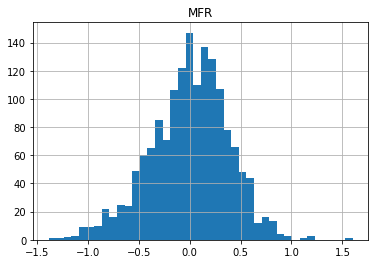

In [30]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [31]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.17
Information Coefficient (P-Value): 0.0


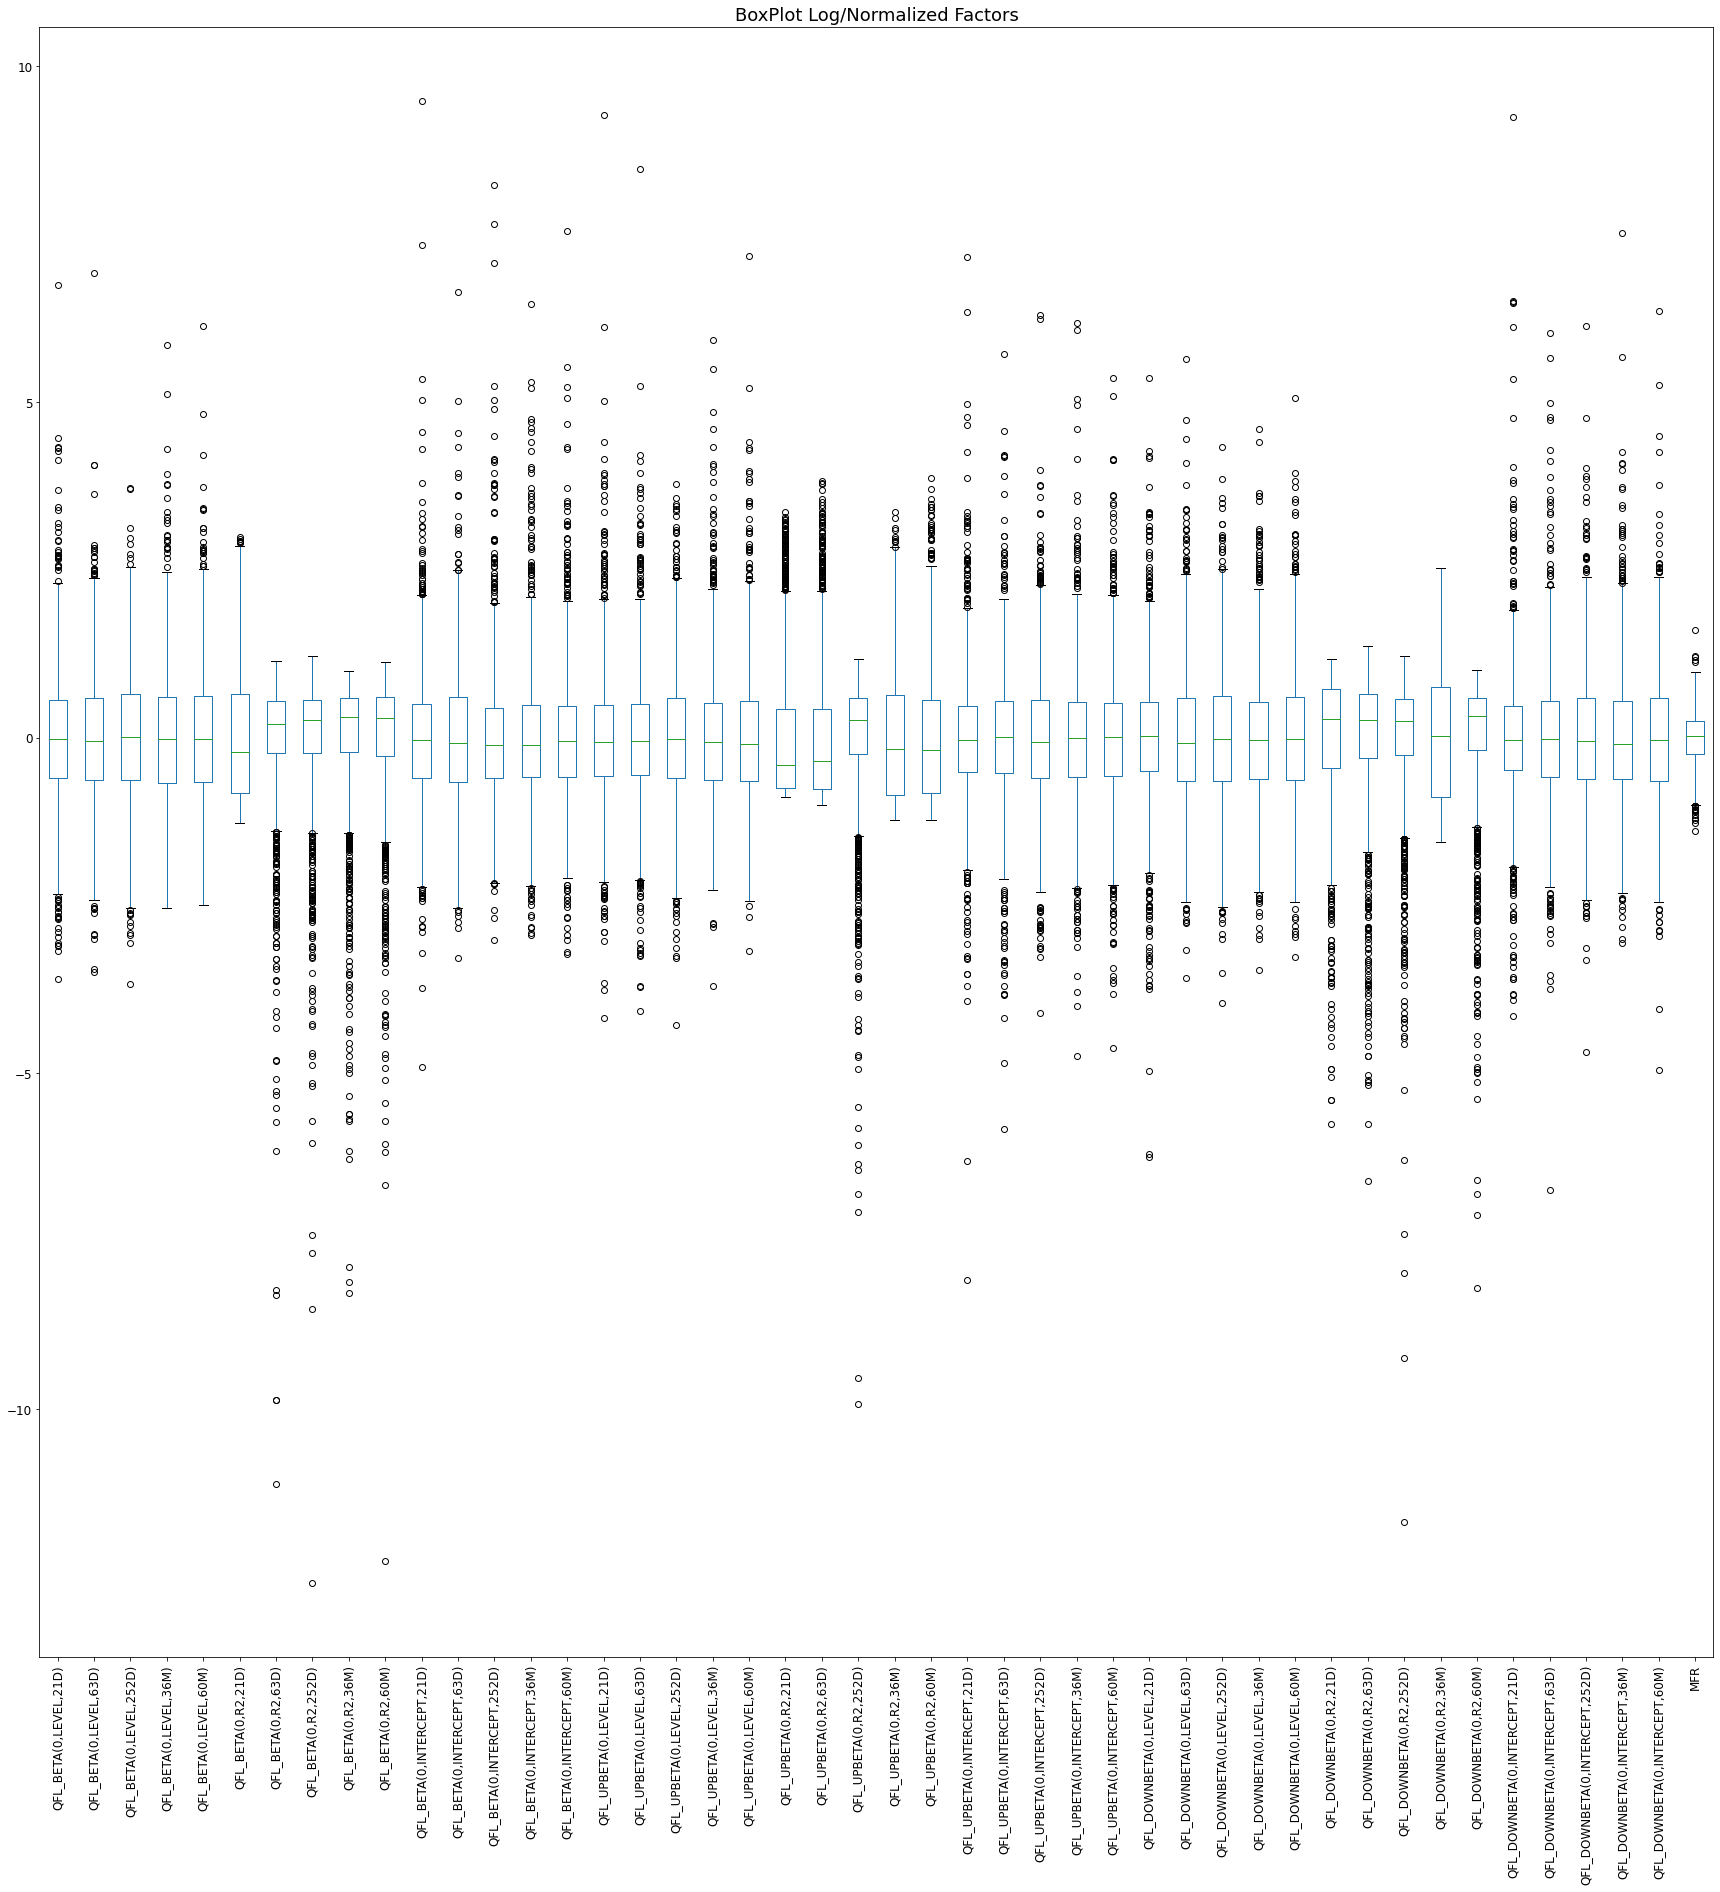

In [32]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [33]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_BETA(0,LEVEL,21D)","QFL_BETA(0,LEVEL,63D)","QFL_BETA(0,LEVEL,252D)","QFL_BETA(0,LEVEL,36M)","QFL_BETA(0,LEVEL,60M)","QFL_BETA(0,R2,21D)","QFL_BETA(0,R2,63D)","QFL_BETA(0,R2,252D)","QFL_BETA(0,R2,36M)","QFL_BETA(0,R2,60M)","QFL_BETA(0,INTERCEPT,21D)","QFL_BETA(0,INTERCEPT,63D)","QFL_BETA(0,INTERCEPT,252D)","QFL_BETA(0,INTERCEPT,36M)","QFL_BETA(0,INTERCEPT,60M)","QFL_UPBETA(0,LEVEL,21D)","QFL_UPBETA(0,LEVEL,63D)","QFL_UPBETA(0,LEVEL,252D)","QFL_UPBETA(0,LEVEL,36M)","QFL_UPBETA(0,LEVEL,60M)","QFL_UPBETA(0,R2,21D)","QFL_UPBETA(0,R2,63D)","QFL_UPBETA(0,R2,252D)","QFL_UPBETA(0,R2,36M)","QFL_UPBETA(0,R2,60M)","QFL_UPBETA(0,INTERCEPT,21D)","QFL_UPBETA(0,INTERCEPT,63D)","QFL_UPBETA(0,INTERCEPT,252D)","QFL_UPBETA(0,INTERCEPT,36M)","QFL_UPBETA(0,INTERCEPT,60M)","QFL_DOWNBETA(0,LEVEL,21D)","QFL_DOWNBETA(0,LEVEL,63D)","QFL_DOWNBETA(0,LEVEL,252D)","QFL_DOWNBETA(0,LEVEL,36M)","QFL_DOWNBETA(0,LEVEL,60M)","QFL_DOWNBETA(0,R2,21D)","QFL_DOWNBETA(0,R2,63D)","QFL_DOWNBETA(0,R2,252D)","QFL_DOWNBETA(0,R2,36M)","QFL_DOWNBETA(0,R2,60M)","QFL_DOWNBETA(0,INTERCEPT,21D)","QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)","QFL_DOWNBETA(0,INTERCEPT,60M)",ison_screen
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,0.861591,1.610198,1.118509,1.302228,1.346245,0.244189,0.624214,0.697611,0.493239,0.436854,0.025345,-0.160741,0.182982,2.127070,1.485300,1.563566,2.037778,1.107488,1.104269,1.464730,0.284010,0.442904,0.526650,0.138878,0.217026,-0.950105,-0.780763,0.215011,3.217354,1.149191,0.890417,1.896566,1.103299,1.027167,1.155172,0.137158,0.531894,0.651620,0.360123,0.375939,0.318550,0.361035,0.119952,-0.119393,0.645002,1
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,1.251734,1.392137,1.124283,0.879081,0.879282,0.450638,0.734557,0.781973,0.664893,0.506620,-0.321641,-0.135252,0.088684,2.014583,1.707961,1.489957,1.349847,1.153005,0.539854,0.767634,0.315103,0.382836,0.644525,0.206734,0.213866,-0.580456,-0.147045,0.079986,3.840337,2.410959,0.327754,1.558148,1.072252,0.483585,0.559072,0.015892,0.668159,0.739606,0.220694,0.250698,-0.715076,0.103369,-0.027884,-1.318583,-0.373123,1
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,0.977121,1.385195,0.683623,1.113462,1.171633,0.179004,0.520609,0.375052,0.426010,0.389396,-0.253297,-0.177563,0.210121,2.062143,1.769571,1.486608,1.762081,0.614779,1.336714,1.087001,0.153935,0.263224,0.218852,0.272714,0.189366,-0.919348,-0.563695,0.388769,1.343956,2.453193,0.481733,1.238941,0.639716,0.512783,0.733700,0.019361,0.391755,0.267635,0.048014,0.111707,-0.306034,-0.302111,-0.004324,-1.605728,-0.928978,1
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,1.431287,1.344539,0.992680,1.309334,1.181302,0.321083,0.475149,0.561336,0.577974,0.432414,-0.430363,-0.143153,0.100999,0.318377,0.728503,2.222191,1.258325,0.903688,1.843832,1.475115,0.267217,0.146442,0.321812,0.397825,0.266027,-1.432395,-0.034543,0.219383,-1.958213,-0.215105,0.214552,1.341049,1.051975,0.863571,0.850114,0.016337,0.367187,0.586196,0.370470,0.305427,-0.758130,-0.163126,0.159252,-1.707052,-0.536148,1
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,1.214249,1.264529,0.945652,1.075778,1.060477,0.546202,0.647995,0.728113,0.610324,0.507022,-0.190792,0.017097,0.061746,0.697114,0.573646,1.406342,0.913093,0.869954,0.951692,1.020823,0.355076,0.218818,0.518126,0.291591,0.259901,-0.413201,0.351598,0.208426,1.159476,0.738445,0.644602,1.476014,0.951700,1.297097,1.056681,0.143165,0.551272,0.709173,0.422939,0.376638,-0.415955,0.248248,-0.013721,1.9695

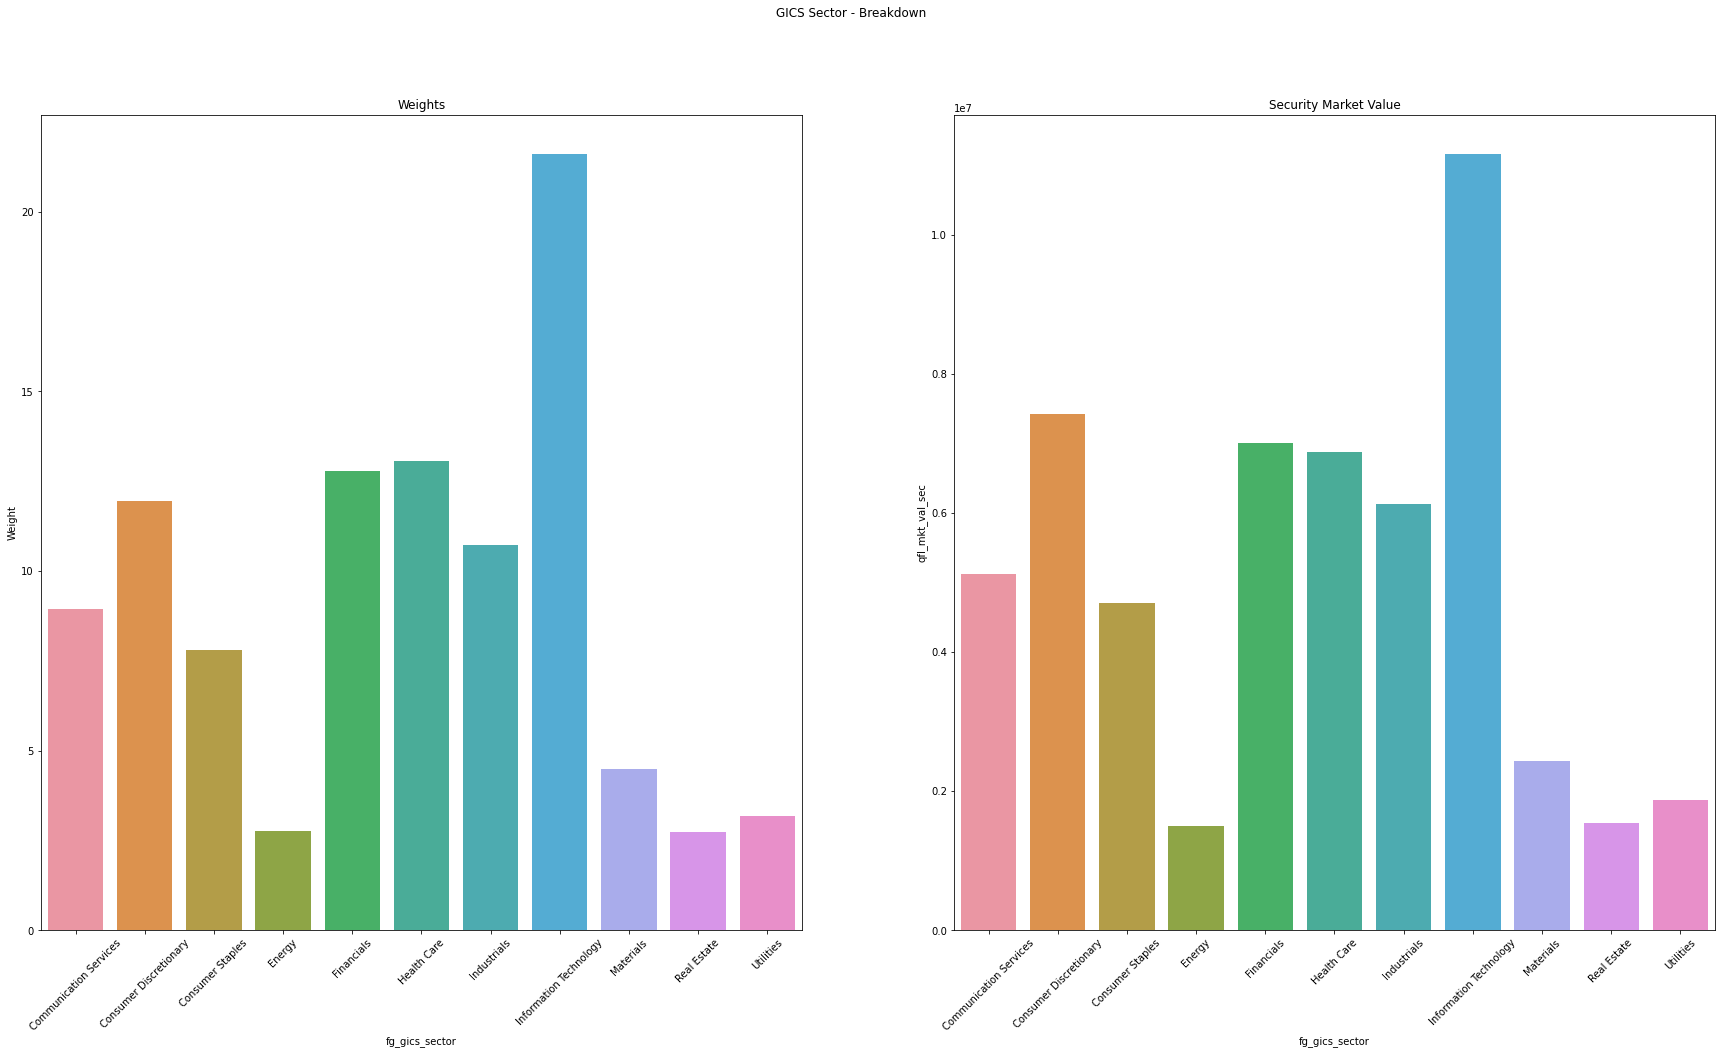

In [34]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

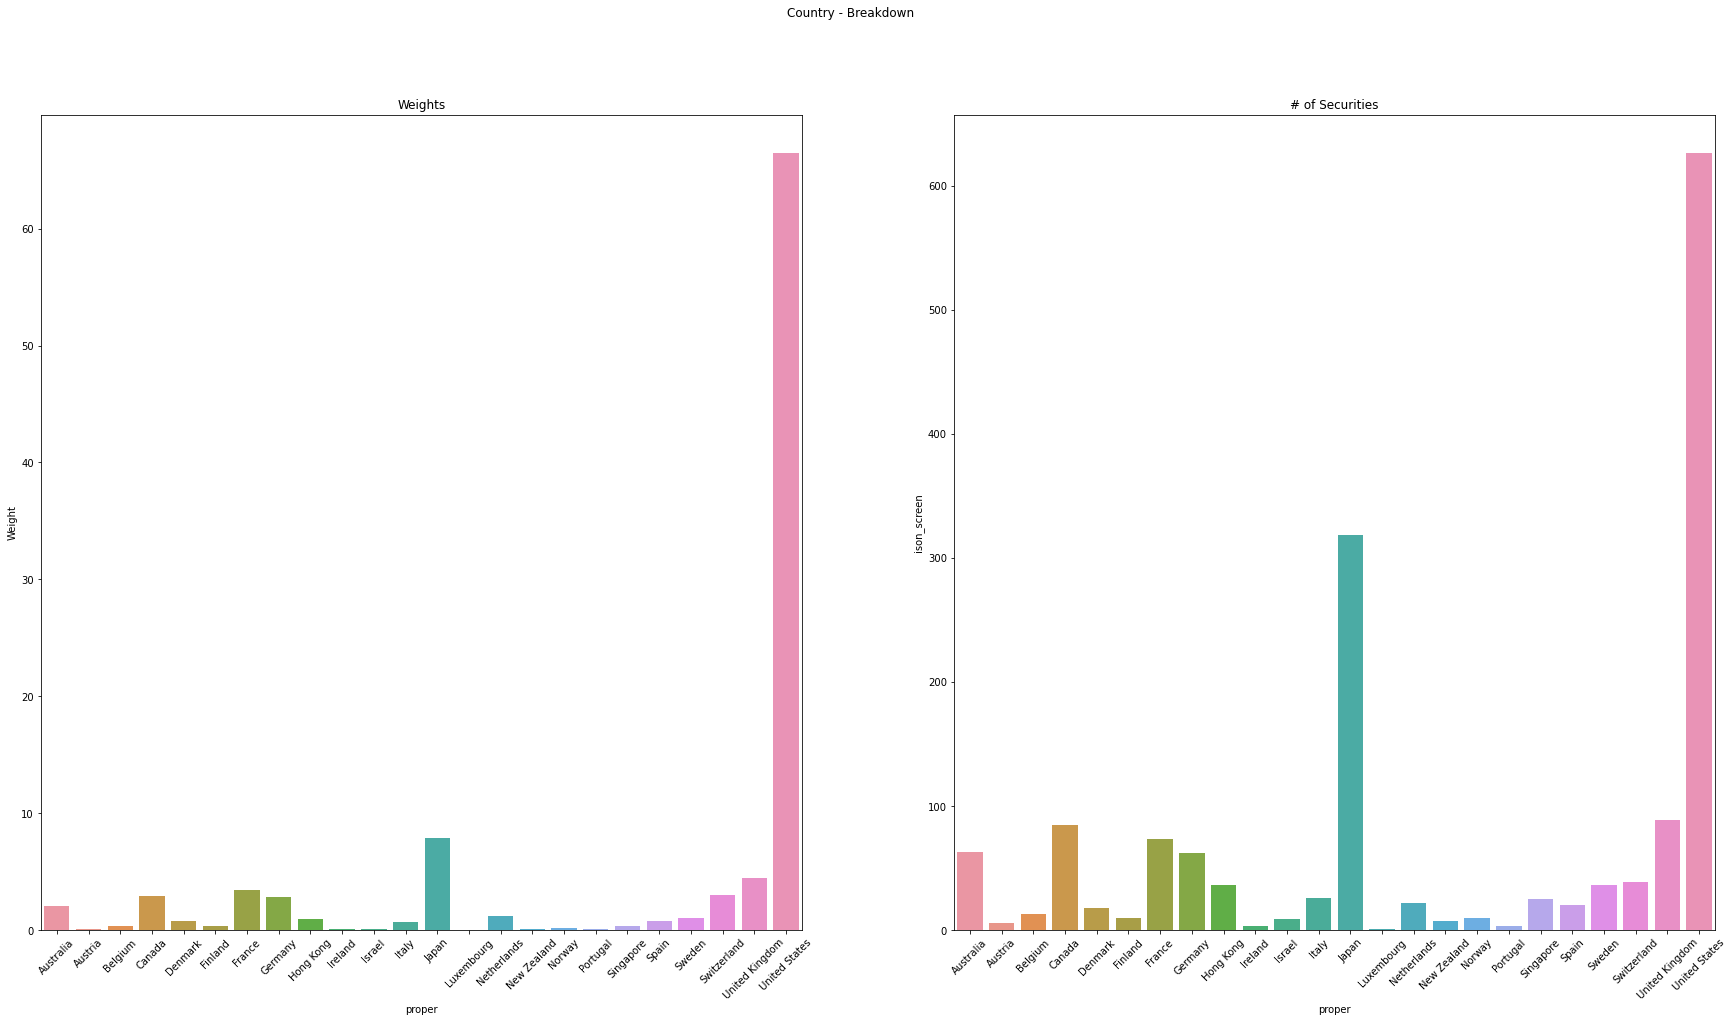

In [35]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

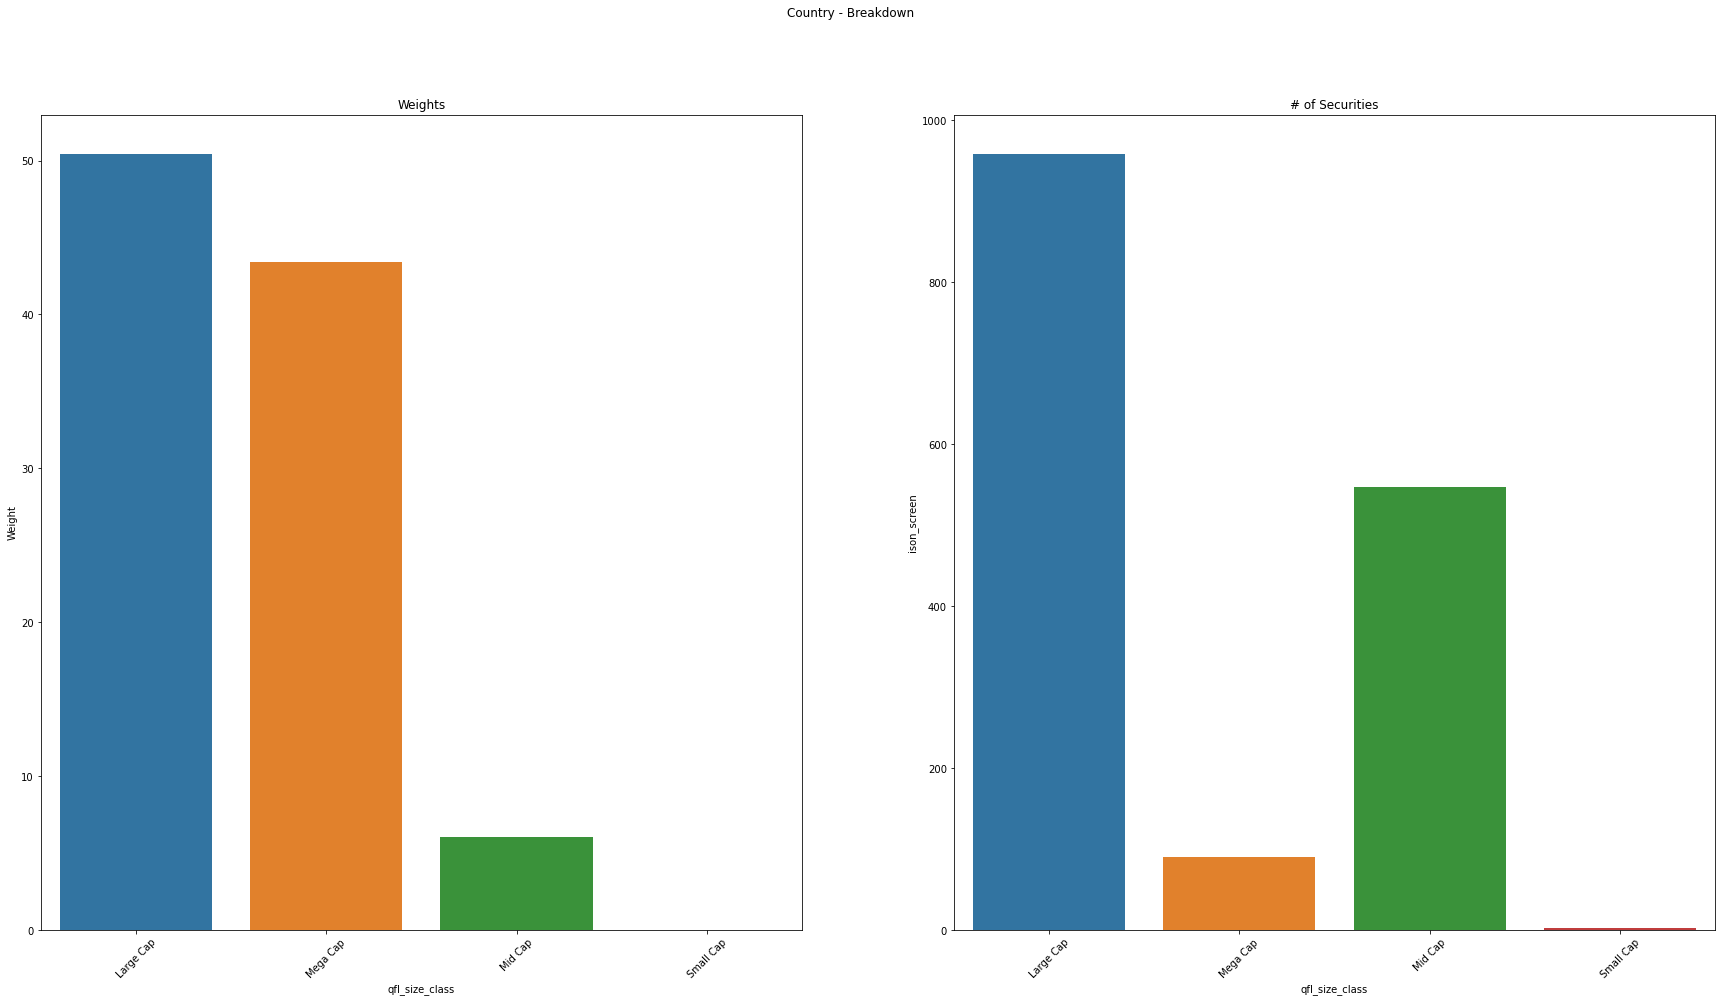

In [36]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [37]:
# Feature Selection

In [38]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [39]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-39-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [40]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


Num Features: 3
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True  True]
Feature Ranking: [34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11
 10  9  8  7  6  5  4  3  2  1  1  1]


In [41]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_DOWNBETA(0,INTERCEPT,63D)', 'QFL_DOWNBETA(0,INTERCEPT,252D)',
       'QFL_DOWNBETA(0,INTERCEPT,36M)'],
      dtype='object')

In [42]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,"QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)"
"QFL_DOWNBETA(0,INTERCEPT,63D)",1.000000,0.435927,0.136095
"QFL_DOWNBETA(0,INTERCEPT,252D)",0.435927,1.000000,0.343730
"QFL_DOWNBETA(0,INTERCEPT,36M)",0.136095,0.343730,1.000000


In [43]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,"QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)"
0,0.361035,0.119952,-0.119393
1,0.103369,-0.027884,-1.318583
2,-0.302111,-0.004324,-1.605728
3,-0.163126,0.159252,-1.707052
4,0.248248,-0.013721,1.969548
...,...,...,...
1595,-0.073195,0.014579,3.147473
1596,-0.232353,-0.161058,-3.069147
1597,-0.397286,-0.226699,1.860700
1598,-0.531136,-0.673074,-5.993121


In [44]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,"QFL_DOWNBETA(0,INTERCEPT,63D)","QFL_DOWNBETA(0,INTERCEPT,252D)","QFL_DOWNBETA(0,INTERCEPT,36M)",MFR
0,0.728590,0.288195,-0.363931,0.217618
1,0.183921,-0.254038,-0.706735,-0.258951
2,-0.673207,-0.167625,-0.788820,-0.543217
3,-0.379412,0.432339,-0.817785,-0.254953
4,0.490174,-0.202091,0.233222,0.173768


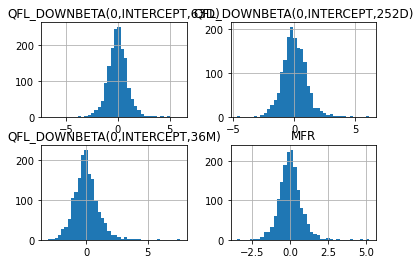

In [45]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [46]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.01
Information Coefficient (P-Value): 0.67


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [47]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.01
Information Coefficient (P-Value): 0.67


### Z-Score + Log-Transformation (All Components)

In [48]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.17
Information Coefficient (P-Value): 0.0


### Z-Score Only (All Components)

In [49]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04
